In [1]:
from smach_utils2 import *
import matplotlib.pyplot as plt
#arm = moveit_commander.MoveGroupCommander('arm')


/home/roboworks/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[ WARN] [1711220679.287204466]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1011.464000 according to authority /pose_integrator
[ WARN] [1711220680.486759721]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1011.891000 according to authority /pose_integrator
[ WARN] [1711220681.305313630]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1012.189000 according to authority /pose_integrator
[ WARN] [1711220681.305364612]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1012.189000 according to authority /pose_integrator
[ WARN] [1711220681.305402894]: TF_REPEATED_DATA ignoring data with redundant timestam

In [2]:
arm=moveit_commander.MoveGroupCommander('arm')

[ WARN] [1711220682.271221372]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1711220682.281810831]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1711220682.282096046]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1711220682.285955531]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1711220682.286363970]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1711220682.457870253]: Kinematics solver doesn't support #attempts any

In [3]:

whole_body=moveit_commander.MoveGroupCommander('whole_body_weighted')

[ WARN] [1711220685.089262736, 1013.565000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1013.624000 according to authority unknown_publisher
[ WARN] [1711220685.199609187, 1013.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1013.683000 according to authority unknown_publisher
[ WARN] [1711220685.513039465, 1013.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1013.801000 according to authority unknown_publisher
[ WARN] [1711220686.351541050, 1014.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1014.147000 according to authority unknown_publisher
[ WARN] [1711220687.272638585, 1014.469000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1014.507000 according to authority unknown_publisher
[ WARN] [1711220687.584694383, 1014.604000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711220693.859498810, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1016.908000 according to authority unknown_publisher
[ WARN] [1711220693.860353410, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1016.908000 according to authority /pose_integrator
[ WARN] [1711220693.860417916, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1016.908000 according to authority /pose_integrator
[ WARN] [1711220693.860468551, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1016.908000 according to authority /pose_integrator
[ WARN] [1711220693.860501092, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1016.908000 according to authority /pose_integrator
[ WARN] [1711220693.860528690, 1016.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

KeyboardInterrupt: 

In [4]:
res = omni_base.move_base(known_location='place_shelf', time_out=200)
high_shelf_place=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])
mid_shelf_place=np.asarray([0.2556342351169577,
 -1.6040815280188854,
 -0.008078345343693893,
 -0.05795663028496589,
 0.0019971082238159354,
 0.0])

low_shelf_place=np.asarray([0.04577467546491997,
 -2.262541528018885,
 0.00010865465630605087,
 0.701618369715034,
 -0.0003068917761841483,
 0.0]
)

[ WARN] [1711220704.849455717, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1020.866000 according to authority /pose_integrator
[ WARN] [1711220704.849534322, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1020.866000 according to authority /pose_integrator
[ WARN] [1711220704.849579521, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1020.866000 according to authority /pose_integrator
[ WARN] [1711220704.849623734, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1020.866000 according to authority /pose_integrator
[ WARN] [1711220704.849672425, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1020.866000 according to authority /pose_integrator
[ WARN] [1711220704.849720433, 1020.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0
  y: 0.0
  yaw: 0.0
  timeout: 200
  known_location: "place_shelf"


[ WARN] [1711220706.621975901, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1021.531000 according to authority unknown_publisher
[ WARN] [1711220706.623450349, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1021.531000 according to authority /pose_integrator
[ WARN] [1711220706.623509304, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1021.531000 according to authority /pose_integrator
[ WARN] [1711220706.623543386, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1021.531000 according to authority /pose_integrator
[ WARN] [1711220706.623579463, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1021.531000 according to authority /pose_integrator
[ WARN] [1711220706.623613780, 1021.489000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220716.556422243, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1024.735000 according to authority /pose_integrator
[ WARN] [1711220716.556505228, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1024.735000 according to authority /pose_integrator
[ WARN] [1711220716.556553617, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1024.735000 according to authority /pose_integrator
[ WARN] [1711220716.556617999, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1024.735000 according to authority /pose_integrator
[ WARN] [1711220716.556680232, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1024.735000 according to authority /pose_integrator
[ WARN] [1711220716.556743807, 1024.735000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220720.331506715, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1025.983000 according to authority unknown_publisher
[ WARN] [1711220720.332575403, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1025.983000 according to authority /pose_integrator
[ WARN] [1711220720.332629582, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1025.983000 according to authority /pose_integrator
[ WARN] [1711220720.332662852, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1025.983000 according to authority /pose_integrator
[ WARN] [1711220720.332708550, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1025.983000 according to authority /pose_integrator
[ WARN] [1711220720.332743360, 1025.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220725.833645326, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1027.922000 according to authority /pose_integrator
[ WARN] [1711220725.833726465, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1027.922000 according to authority /pose_integrator
[ WARN] [1711220725.833786045, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1027.922000 according to authority /pose_integrator
[ WARN] [1711220725.833839301, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1027.922000 according to authority /pose_integrator
[ WARN] [1711220725.833882860, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1027.922000 according to authority /pose_integrator
[ WARN] [1711220725.834175753, 1027.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220731.302567614, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1029.940000 according to authority unknown_publisher
[ WARN] [1711220731.303321865, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1029.940000 according to authority /pose_integrator
[ WARN] [1711220731.303396123, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1029.940000 according to authority /pose_integrator
[ WARN] [1711220731.303458704, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1029.940000 according to authority /pose_integrator
[ WARN] [1711220731.303513906, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1029.940000 according to authority /pose_integrator
[ WARN] [1711220731.303570605, 1029.895000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220737.008326405, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1032.078000 according to authority /pose_integrator
[ WARN] [1711220737.008411405, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1032.078000 according to authority /pose_integrator
[ WARN] [1711220737.008470924, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1032.078000 according to authority /pose_integrator
[ WARN] [1711220737.008514239, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1032.078000 according to authority /pose_integrator
[ WARN] [1711220737.008558409, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1032.078000 according to authority /pose_integrator
[ WARN] [1711220737.008613667, 1032.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220741.557427504, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1033.733000 according to authority unknown_publisher
[ WARN] [1711220741.562035087, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1033.733000 according to authority /pose_integrator
[ WARN] [1711220741.562104762, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1033.733000 according to authority /pose_integrator
[ WARN] [1711220741.562145483, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1033.733000 according to authority /pose_integrator
[ WARN] [1711220741.562179433, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1033.733000 according to authority /pose_integrator
[ WARN] [1711220741.562210259, 1033.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220746.546368673, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1035.589000 according to authority /pose_integrator
[ WARN] [1711220746.546441033, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1035.589000 according to authority /pose_integrator
[ WARN] [1711220746.546484246, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1035.589000 according to authority /pose_integrator
[ WARN] [1711220746.546523556, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1035.589000 according to authority /pose_integrator
[ WARN] [1711220746.546565513, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1035.589000 according to authority /pose_integrator
[ WARN] [1711220746.546602775, 1035.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220750.262817454, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1037.118000 according to authority unknown_publisher
[ WARN] [1711220750.263823786, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1037.118000 according to authority /pose_integrator
[ WARN] [1711220750.263893024, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1037.118000 according to authority /pose_integrator
[ WARN] [1711220750.263944153, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1037.118000 according to authority /pose_integrator
[ WARN] [1711220750.263996445, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1037.118000 according to authority /pose_integrator
[ WARN] [1711220750.264044845, 1037.061000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220753.176149547, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1038.325000 according to authority /pose_integrator
[ WARN] [1711220753.176220273, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1038.325000 according to authority /pose_integrator
[ WARN] [1711220753.176261128, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1038.325000 according to authority /pose_integrator
[ WARN] [1711220753.176317252, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1038.325000 according to authority /pose_integrator
[ WARN] [1711220753.176366461, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1038.325000 according to authority /pose_integrator
[ WARN] [1711220753.176416166, 1038.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220757.357434723, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1039.910000 according to authority /pose_integrator
[ WARN] [1711220757.357520697, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1039.910000 according to authority /pose_integrator
[ WARN] [1711220757.357581232, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1039.910000 according to authority /pose_integrator
[ WARN] [1711220757.357641970, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1039.910000 according to authority /pose_integrator
[ WARN] [1711220757.357687775, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1039.910000 according to authority /pose_integrator
[ WARN] [1711220757.357737291, 1039.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220761.519534683, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1041.597000 according to authority /pose_integrator
[ WARN] [1711220761.519607815, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1041.597000 according to authority /pose_integrator
[ WARN] [1711220761.519646578, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1041.597000 according to authority /pose_integrator
[ WARN] [1711220761.519695526, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1041.597000 according to authority /pose_integrator
[ WARN] [1711220761.519743246, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1041.597000 according to authority /pose_integrator
[ WARN] [1711220761.519797960, 1041.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220764.880138244, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1042.721000 according to authority /pose_integrator
[ WARN] [1711220764.880208092, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1042.721000 according to authority /pose_integrator
[ WARN] [1711220764.880259349, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1042.721000 according to authority /pose_integrator
[ WARN] [1711220764.880302771, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1042.721000 according to authority /pose_integrator
[ WARN] [1711220764.880340743, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1042.721000 according to authority /pose_integrator
[ WARN] [1711220764.880400032, 1042.653000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220771.144629184, 1045.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1045.133000 according to authority unknown_publisher
[ WARN] [1711220771.144998150, 1045.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1045.133000 according to authority /pose_integrator
[ WARN] [1711220771.145061716, 1045.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1045.133000 according to authority /pose_integrator
[ WARN] [1711220771.145121051, 1045.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1045.133000 according to authority /pose_integrator
[ WARN] [1711220771.145173532, 1045.132000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1045.133000 according to authority /pose_integrator
[ WARN] [1711220771.145223838, 1045.133000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [7]:
head.set_joint_values([-0.5,-0.65])
arm.set_named_target('go')
arm.go()

[ WARN] [1711220796.459202716, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1054.649000 according to authority unknown_publisher
[ WARN] [1711220796.459374382, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1054.649000 according to authority /pose_integrator
[ WARN] [1711220796.459468485, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1054.649000 according to authority /pose_integrator
[ WARN] [1711220796.459518953, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1054.649000 according to authority /pose_integrator
[ WARN] [1711220796.459556790, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1054.649000 according to authority /pose_integrator
[ WARN] [1711220796.459590669, 1054.620000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

True

[ WARN] [1711220800.185761562, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.040000 according to authority /pose_integrator
[ WARN] [1711220800.185830977, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.040000 according to authority /pose_integrator
[ WARN] [1711220800.185869652, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.040000 according to authority /pose_integrator
[ WARN] [1711220800.185902814, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.040000 according to authority /pose_integrator
[ WARN] [1711220800.185940615, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.040000 according to authority /pose_integrator
[ WARN] [1711220800.185983293, 1056.040000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

In [8]:

rospy.sleep(0.6)
rospy.sleep(0.6)
image= cv2.cvtColor(rgbd.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)

[ WARN] [1711220802.079874468, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.691000 according to authority unknown_publisher
[ WARN] [1711220802.080082501, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.691000 according to authority /pose_integrator
[ WARN] [1711220802.080135127, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.691000 according to authority /pose_integrator
[ WARN] [1711220802.080185722, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.691000 according to authority /pose_integrator
[ WARN] [1711220802.080235326, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1056.691000 according to authority /pose_integrator
[ WARN] [1711220802.080289963, 1056.691000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220806.108163285, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.237000 according to authority unknown_publisher
[ WARN] [1711220806.108563223, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.237000 according to authority /pose_integrator
[ WARN] [1711220806.108632658, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.237000 according to authority /pose_integrator
[ WARN] [1711220806.108695582, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.237000 according to authority /pose_integrator
[ WARN] [1711220806.108745837, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.237000 according to authority /pose_integrator
[ WARN] [1711220806.108804114, 1058.204000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

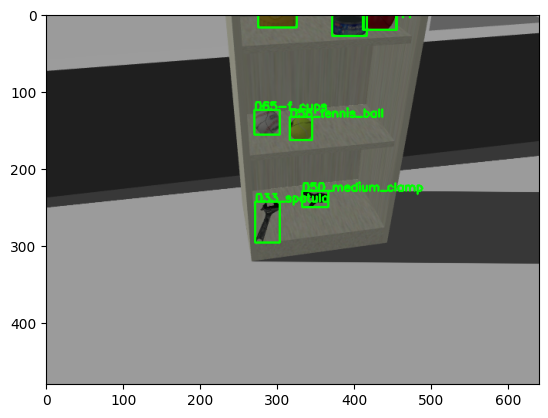

In [9]:

plt.imshow(debug_image)

#############Finding placing in plane#################### 0.0


[ WARN] [1711220806.564647194, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.384000 according to authority /pose_integrator
[ WARN] [1711220806.564730622, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.384000 according to authority /pose_integrator
[ WARN] [1711220806.564780289, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.384000 according to authority /pose_integrator
[ WARN] [1711220806.564827997, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.384000 according to authority /pose_integrator
[ WARN] [1711220806.564867081, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1058.384000 according to authority /pose_integrator
[ WARN] [1711220806.564899484, 1058.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

Placing Area at (8.285682678222656, 6.019772529602051, 0.383586049079895)


[ WARN] [1711220809.801392455, 1059.405000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.448000 according to authority unknown_publisher
[ WARN] [1711220809.804392120, 1059.446000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.448000 according to authority /pose_integrator
[ WARN] [1711220809.804468701, 1059.447000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.448000 according to authority /pose_integrator
[ WARN] [1711220809.804514710, 1059.447000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.448000 according to authority /pose_integrator
[ WARN] [1711220809.804568552, 1059.447000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.448000 according to authority /pose_integrator
[ WARN] [1711220809.804619015, 1059.448000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

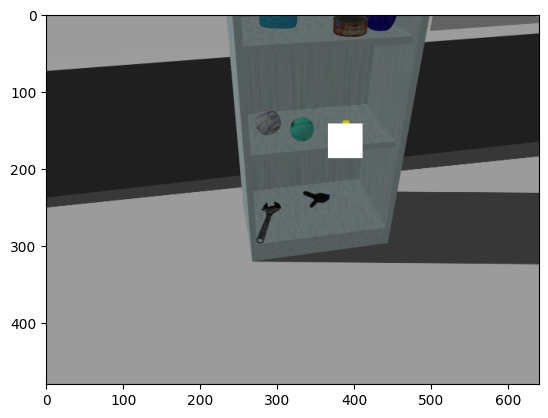

[ WARN] [1711220810.029112726, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.524000 according to authority /pose_integrator
[ WARN] [1711220810.029220483, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.524000 according to authority /pose_integrator
[ WARN] [1711220810.029285342, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.524000 according to authority /pose_integrator
[ WARN] [1711220810.029341285, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.524000 according to authority /pose_integrator
[ WARN] [1711220810.029386417, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.524000 according to authority /pose_integrator
[ WARN] [1711220810.029425928, 1059.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

In [10]:
request= segmentation_server.request_class() 

print ('#############Finding placing in plane####################',request.height.data)
#request.height.data=-1
request.height.data=0.38  #MID SHELF FOR PLACING 
area_name_numbered= 'mid_shelf'


res=placing_finder_server.call(request)
#succ=seg_res_tf(res)
print (f'Placing Area at {res.poses.data}')
tf_man.pub_static_tf(pos=[res.poses.data[0], res.poses.data[1],res.poses.data[2]], rot =[0,0,0,1], point_name='placing_area')
img=bridge.imgmsg_to_cv2(res.im_out.image_msgs[0])
#cv2.imshow('our of res'  , img)
plt.imshow(img)

In [11]:
res = omni_base.move_base(known_location='place_shelf', time_out=12)


header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0
  y: 0.0
  yaw: 0.0
  timeout: 12
  known_location: "place_shelf"


[ WARN] [1711220810.594275522, 1059.693000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.728000 according to authority unknown_publisher
[ WARN] [1711220810.607636443, 1059.728000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.728000 according to authority /pose_integrator
[ WARN] [1711220810.607736288, 1059.728000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.728000 according to authority /pose_integrator
[ WARN] [1711220810.607782380, 1059.728000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.728000 according to authority /pose_integrator
[ WARN] [1711220810.607820420, 1059.728000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1059.728000 according to authority /pose_integrator
[ WARN] [1711220810.607880372, 1059.728000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220815.803633594, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1061.519000 according to authority unknown_publisher
[ WARN] [1711220815.803866640, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1061.519000 according to authority /pose_integrator
[ WARN] [1711220815.803932289, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1061.519000 according to authority /pose_integrator
[ WARN] [1711220815.803988818, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1061.519000 according to authority /pose_integrator
[ WARN] [1711220815.804039789, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1061.519000 according to authority /pose_integrator
[ WARN] [1711220815.804092799, 1061.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220819.389763833, 1062.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1062.776000 according to authority unknown_publisher
[ WARN] [1711220819.398503981, 1062.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1062.776000 according to authority /pose_integrator
[ WARN] [1711220819.398599390, 1062.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1062.776000 according to authority /pose_integrator
[ WARN] [1711220819.398647546, 1062.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1062.776000 according to authority /pose_integrator
[ WARN] [1711220819.398687676, 1062.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1062.776000 according to authority /pose_integrator
[ WARN] [1711220819.398729503, 1062.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [12]:
base_grasp_D(tf_name='placing_area',d_x=0.76, d_y=0.0,timeout=30)
arm.go (mid_shelf_place)
base_grasp_D(tf_name='placing_area',d_x=0.6, d_y=0.0,timeout=30)
gripper.open()

0.0
[INFO] [1711220820.415737, 1063.161000]: error: 0.40, -0.34, angle 0.00, target obj frame placing_area
[INFO] [1711220820.419065, 1063.161000]: Pose: 1.16, -0.34, angle 0.00, target obj frame placing_area


[ WARN] [1711220820.960344925, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.365000 according to authority unknown_publisher
[ WARN] [1711220820.961925475, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.365000 according to authority /pose_integrator
[ WARN] [1711220820.961986519, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.365000 according to authority /pose_integrator
[ WARN] [1711220820.962039809, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.365000 according to authority /pose_integrator
[ WARN] [1711220820.962076203, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.365000 according to authority /pose_integrator
[ WARN] [1711220820.962106441, 1063.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.215392703116017
[INFO] [1711220820.971394, 1063.365000]: error: 0.31, -0.58, angle 0.22, target obj frame placing_area
[INFO] [1711220820.980737, 1063.365000]: Pose: 1.07, -0.58, angle 0.22, target obj frame placing_area


[ WARN] [1711220821.295311094, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.502000 according to authority unknown_publisher
[ WARN] [1711220821.296939111, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.502000 according to authority /pose_integrator
[ WARN] [1711220821.297004831, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.502000 according to authority /pose_integrator
[ WARN] [1711220821.297051672, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.502000 according to authority /pose_integrator
[ WARN] [1711220821.297092047, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.502000 according to authority /pose_integrator
[ WARN] [1711220821.297132261, 1063.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.23160838916651816
[INFO] [1711220821.631928, 1063.613000]: error: 0.28, -0.58, angle 0.23, target obj frame placing_area
[INFO] [1711220821.634598, 1063.613000]: Pose: 1.04, -0.58, angle 0.23, target obj frame placing_area


[ WARN] [1711220821.992371746, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.716000 according to authority /pose_integrator
[ WARN] [1711220821.992434135, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.716000 according to authority /pose_integrator
[ WARN] [1711220821.992470314, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.716000 according to authority /pose_integrator
[ WARN] [1711220821.992516070, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.716000 according to authority /pose_integrator
[ WARN] [1711220821.992554568, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.716000 according to authority /pose_integrator
[ WARN] [1711220821.992598044, 1063.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

0.20422571760079244
[INFO] [1711220822.363049, 1063.842000]: error: 0.28, -0.51, angle 0.20, target obj frame placing_area
[INFO] [1711220822.366532, 1063.842000]: Pose: 1.04, -0.51, angle 0.20, target obj frame placing_area


[ WARN] [1711220822.635478236, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.930000 according to authority /pose_integrator
[ WARN] [1711220822.635574759, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.930000 according to authority /pose_integrator
[ WARN] [1711220822.635622227, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.930000 according to authority /pose_integrator
[ WARN] [1711220822.635678577, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.930000 according to authority /pose_integrator
[ WARN] [1711220822.635730875, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1063.930000 according to authority /pose_integrator
[ WARN] [1711220822.635779142, 1063.896000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

0.18413206473952992
[INFO] [1711220823.029844, 1064.076000]: error: 0.29, -0.48, angle 0.18, target obj frame placing_area
[INFO] [1711220823.031658, 1064.079000]: Pose: 1.05, -0.48, angle 0.18, target obj frame placing_area
0.12777204417877197
[INFO] [1711220823.689986, 1064.288000]: error: 0.29, -0.37, angle 0.13, target obj frame placing_area
[INFO] [1711220823.691916, 1064.288000]: Pose: 1.05, -0.37, angle 0.13, target obj frame placing_area
0.09444565735047039
[INFO] [1711220824.265496, 1064.506000]: error: 0.29, -0.31, angle 0.09, target obj frame placing_area
[INFO] [1711220824.273164, 1064.506000]: Pose: 1.05, -0.31, angle 0.09, target obj frame placing_area


[ WARN] [1711220824.357976494, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.556000 according to authority /pose_integrator
[ WARN] [1711220824.358053443, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.556000 according to authority /pose_integrator
[ WARN] [1711220824.358107395, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.556000 according to authority /pose_integrator
[ WARN] [1711220824.358150860, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.556000 according to authority /pose_integrator
[ WARN] [1711220824.358193644, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.556000 according to authority /pose_integrator
[ WARN] [1711220824.358242321, 1064.506000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

0.06395440285993925
[INFO] [1711220824.833566, 1064.715000]: error: 0.29, -0.25, angle 0.06, target obj frame placing_area
[INFO] [1711220824.835150, 1064.715000]: Pose: 1.05, -0.25, angle 0.06, target obj frame placing_area


[ WARN] [1711220824.928235890, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.750000 according to authority unknown_publisher
[ WARN] [1711220824.932787802, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.750000 according to authority /pose_integrator
[ WARN] [1711220824.932869300, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.750000 according to authority /pose_integrator
[ WARN] [1711220824.932926850, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.750000 according to authority /pose_integrator
[ WARN] [1711220824.932966911, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1064.750000 according to authority /pose_integrator
[ WARN] [1711220824.933011715, 1064.715000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.06495033446370302
[INFO] [1711220825.628328, 1064.936000]: error: 0.27, -0.23, angle 0.06, target obj frame placing_area
[INFO] [1711220825.631017, 1064.936000]: Pose: 1.03, -0.23, angle 0.06, target obj frame placing_area


[ WARN] [1711220826.101202203, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.087000 according to authority unknown_publisher
[ WARN] [1711220826.102172492, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.087000 according to authority /pose_integrator
[ WARN] [1711220826.102231437, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.087000 according to authority /pose_integrator
[ WARN] [1711220826.102271026, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.087000 according to authority /pose_integrator
[ WARN] [1711220826.102315726, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.087000 according to authority /pose_integrator
[ WARN] [1711220826.102364717, 1065.036000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.06468622059646933
[INFO] [1711220826.325770, 1065.141000]: error: 0.26, -0.21, angle 0.06, target obj frame placing_area
[INFO] [1711220826.330664, 1065.141000]: Pose: 1.02, -0.21, angle 0.06, target obj frame placing_area


[ WARN] [1711220826.540517440, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.201000 according to authority unknown_publisher
[ WARN] [1711220826.542710779, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.201000 according to authority /pose_integrator
[ WARN] [1711220826.542786231, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.201000 according to authority /pose_integrator
[ WARN] [1711220826.542833323, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.201000 according to authority /pose_integrator
[ WARN] [1711220826.542877064, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1065.201000 according to authority /pose_integrator
[ WARN] [1711220826.542916486, 1065.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.06425838323990907
[INFO] [1711220827.086298, 1065.349000]: error: 0.25, -0.20, angle 0.06, target obj frame placing_area
[INFO] [1711220827.090659, 1065.349000]: Pose: 1.01, -0.20, angle 0.06, target obj frame placing_area
0.06331377419090267
[INFO] [1711220827.916991, 1065.570000]: error: 0.24, -0.18, angle 0.06, target obj frame placing_area
[INFO] [1711220827.923280, 1065.570000]: Pose: 1.00, -0.18, angle 0.06, target obj frame placing_area
0.06313083849754753
[INFO] [1711220828.547209, 1065.780000]: error: 0.23, -0.18, angle 0.06, target obj frame placing_area
[INFO] [1711220828.552160, 1065.780000]: Pose: 0.99, -0.18, angle 0.06, target obj frame placing_area
0.061673771361662855
[INFO] [1711220829.201854, 1065.990000]: error: 0.22, -0.16, angle 0.06, target obj frame placing_area
[INFO] [1711220829.205510, 1065.990000]: Pose: 0.98, -0.16, angle 0.06, target obj frame placing_area


[ WARN] [1711220829.450935086, 1066.086000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.111000 according to authority unknown_publisher
[ WARN] [1711220829.454561259, 1066.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.111000 according to authority /pose_integrator
[ WARN] [1711220829.454640199, 1066.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.111000 according to authority /pose_integrator
[ WARN] [1711220829.454682885, 1066.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.111000 according to authority /pose_integrator
[ WARN] [1711220829.454717141, 1066.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.111000 according to authority /pose_integrator
[ WARN] [1711220829.454753646, 1066.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.0604716080183918
[INFO] [1711220829.792597, 1066.198000]: error: 0.21, -0.15, angle 0.06, target obj frame placing_area
[INFO] [1711220829.809408, 1066.201000]: Pose: 0.97, -0.15, angle 0.06, target obj frame placing_area
0.059946165862342804
[INFO] [1711220830.441330, 1066.405000]: error: 0.20, -0.14, angle 0.06, target obj frame placing_area
[INFO] [1711220830.444378, 1066.405000]: Pose: 0.96, -0.14, angle 0.06, target obj frame placing_area
0.05995740115260917
[INFO] [1711220831.181482, 1066.635000]: error: 0.19, -0.13, angle 0.06, target obj frame placing_area
[INFO] [1711220831.183965, 1066.635000]: Pose: 0.95, -0.13, angle 0.06, target obj frame placing_area
0.05978201591050558
[INFO] [1711220831.870678, 1066.863000]: error: 0.18, -0.11, angle 0.06, target obj frame placing_area
[INFO] [1711220831.874135, 1066.863000]: Pose: 0.94, -0.11, angle 0.06, target obj frame placing_area


[ WARN] [1711220831.969893698, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.897000 according to authority unknown_publisher
[ WARN] [1711220831.971504186, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.897000 according to authority /pose_integrator
[ WARN] [1711220831.971593267, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.897000 according to authority /pose_integrator
[ WARN] [1711220831.971636092, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.897000 according to authority /pose_integrator
[ WARN] [1711220831.971669368, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1066.897000 according to authority /pose_integrator
[ WARN] [1711220831.971705438, 1066.897000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.060389374361100145
[INFO] [1711220832.539634, 1067.065000]: error: 0.17, -0.11, angle 0.06, target obj frame placing_area
[INFO] [1711220832.543050, 1067.065000]: Pose: 0.93, -0.11, angle 0.06, target obj frame placing_area


[ WARN] [1711220832.796394330, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.155000 according to authority unknown_publisher
[ WARN] [1711220832.797176427, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.155000 according to authority /pose_integrator
[ WARN] [1711220832.797236509, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.155000 according to authority /pose_integrator
[ WARN] [1711220832.797276390, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.155000 according to authority /pose_integrator
[ WARN] [1711220832.797310131, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.155000 according to authority /pose_integrator
[ WARN] [1711220832.797351741, 1067.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.06054892070338225
[INFO] [1711220833.151339, 1067.276000]: error: 0.17, -0.10, angle 0.06, target obj frame placing_area
[INFO] [1711220833.156799, 1067.276000]: Pose: 0.93, -0.10, angle 0.06, target obj frame placing_area


[ WARN] [1711220833.246895529, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.310000 according to authority /pose_integrator
[ WARN] [1711220833.246962130, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.310000 according to authority /pose_integrator
[ WARN] [1711220833.247028412, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.310000 according to authority /pose_integrator
[ WARN] [1711220833.247085053, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.310000 according to authority /pose_integrator
[ WARN] [1711220833.247137651, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.310000 according to authority /pose_integrator
[ WARN] [1711220833.247194782, 1067.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

0.06052595218559187
[INFO] [1711220833.793748, 1067.484000]: error: 0.16, -0.10, angle 0.06, target obj frame placing_area
[INFO] [1711220833.801354, 1067.486000]: Pose: 0.92, -0.10, angle 0.06, target obj frame placing_area


[ WARN] [1711220834.221325118, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.592000 according to authority unknown_publisher
[ WARN] [1711220834.224082551, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.592000 according to authority /pose_integrator
[ WARN] [1711220834.224152831, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.592000 according to authority /pose_integrator
[ WARN] [1711220834.224218465, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.592000 according to authority /pose_integrator
[ WARN] [1711220834.224287293, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.592000 according to authority /pose_integrator
[ WARN] [1711220834.224348152, 1067.540000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.061107497235094455
[INFO] [1711220834.556331, 1067.704000]: error: 0.15, -0.09, angle 0.06, target obj frame placing_area
[INFO] [1711220834.558607, 1067.704000]: Pose: 0.91, -0.09, angle 0.06, target obj frame placing_area
0.06045960503434156
[INFO] [1711220835.049604, 1067.905000]: error: 0.15, -0.08, angle 0.06, target obj frame placing_area
[INFO] [1711220835.052690, 1067.905000]: Pose: 0.91, -0.08, angle 0.06, target obj frame placing_area


[ WARN] [1711220835.155101883, 1067.905000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.936000 according to authority unknown_publisher
[ WARN] [1711220835.157603356, 1067.936000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.936000 according to authority /pose_integrator
[ WARN] [1711220835.157661047, 1067.936000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.936000 according to authority /pose_integrator
[ WARN] [1711220835.157706093, 1067.936000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.936000 according to authority /pose_integrator
[ WARN] [1711220835.157740536, 1067.936000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1067.936000 according to authority /pose_integrator
[ WARN] [1711220835.157772953, 1067.936000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.06008151465509437
[INFO] [1711220835.751574, 1068.107000]: error: 0.14, -0.08, angle 0.06, target obj frame placing_area
[INFO] [1711220835.770115, 1068.107000]: Pose: 0.90, -0.08, angle 0.06, target obj frame placing_area
0.05965732201688834
[INFO] [1711220836.454952, 1068.336000]: error: 0.14, -0.07, angle 0.06, target obj frame placing_area
[INFO] [1711220836.456874, 1068.336000]: Pose: 0.90, -0.07, angle 0.06, target obj frame placing_area


[ WARN] [1711220836.738954397, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.457000 according to authority unknown_publisher
[ WARN] [1711220836.739739344, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.457000 according to authority /pose_integrator
[ WARN] [1711220836.739791031, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.457000 according to authority /pose_integrator
[ WARN] [1711220836.739834187, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.457000 according to authority /pose_integrator
[ WARN] [1711220836.739880270, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.457000 according to authority /pose_integrator
[ WARN] [1711220836.739935484, 1068.421000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05959434921652629
[INFO] [1711220836.990532, 1068.547000]: error: 0.13, -0.07, angle 0.06, target obj frame placing_area
[INFO] [1711220836.993331, 1068.547000]: Pose: 0.89, -0.07, angle 0.06, target obj frame placing_area
0.05899710568523342
[INFO] [1711220837.520057, 1068.755000]: error: 0.13, -0.06, angle 0.06, target obj frame placing_area
[INFO] [1711220837.522523, 1068.755000]: Pose: 0.89, -0.06, angle 0.06, target obj frame placing_area


[ WARN] [1711220837.938870534, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.922000 according to authority unknown_publisher
[ WARN] [1711220837.941003695, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.922000 according to authority /pose_integrator
[ WARN] [1711220837.941076740, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.922000 according to authority /pose_integrator
[ WARN] [1711220837.941125075, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.922000 according to authority /pose_integrator
[ WARN] [1711220837.941167753, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.922000 according to authority /pose_integrator
[ WARN] [1711220837.941205193, 1068.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05890512271124271
[INFO] [1711220838.035118, 1068.967000]: error: 0.12, -0.06, angle 0.06, target obj frame placing_area
[INFO] [1711220838.036730, 1068.967000]: Pose: 0.88, -0.06, angle 0.06, target obj frame placing_area


[ WARN] [1711220838.279375069, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.052000 according to authority unknown_publisher
[ WARN] [1711220838.281977586, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.052000 according to authority /pose_integrator
[ WARN] [1711220838.282036006, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.052000 according to authority /pose_integrator
[ WARN] [1711220838.282070264, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.052000 according to authority /pose_integrator
[ WARN] [1711220838.282100533, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.052000 according to authority /pose_integrator
[ WARN] [1711220838.282146910, 1069.052000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05854551858800372
[INFO] [1711220838.648340, 1069.170000]: error: 0.12, -0.06, angle 0.06, target obj frame placing_area
[INFO] [1711220838.653831, 1069.171000]: Pose: 0.88, -0.06, angle 0.06, target obj frame placing_area
0.057363006944172845
[INFO] [1711220839.347244, 1069.383000]: error: 0.11, -0.05, angle 0.06, target obj frame placing_area
[INFO] [1711220839.351701, 1069.383000]: Pose: 0.87, -0.05, angle 0.06, target obj frame placing_area
0.05627997273967056
[INFO] [1711220839.951738, 1069.609000]: error: 0.11, -0.05, angle 0.06, target obj frame placing_area
[INFO] [1711220839.968642, 1069.609000]: Pose: 0.87, -0.05, angle 0.06, target obj frame placing_area


[ WARN] [1711220840.443700693, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.755000 according to authority unknown_publisher
[ WARN] [1711220840.444190839, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.755000 according to authority /pose_integrator
[ WARN] [1711220840.444253577, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.755000 according to authority /pose_integrator
[ WARN] [1711220840.444303322, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.755000 according to authority /pose_integrator
[ WARN] [1711220840.444348362, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1069.755000 according to authority /pose_integrator
[ WARN] [1711220840.444389488, 1069.738000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05507711512951463
[INFO] [1711220840.638301, 1069.811000]: error: 0.11, -0.04, angle 0.06, target obj frame placing_area
[INFO] [1711220840.640334, 1069.811000]: Pose: 0.87, -0.04, angle 0.06, target obj frame placing_area
0.05278810077435758
[INFO] [1711220841.187795, 1070.029000]: error: 0.10, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220841.193998, 1070.029000]: Pose: 0.86, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220841.189909774, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.029000 according to authority unknown_publisher
[ WARN] [1711220841.190521527, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.029000 according to authority /pose_integrator
[ WARN] [1711220841.190620219, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.029000 according to authority /pose_integrator
[ WARN] [1711220841.190692839, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.029000 according to authority /pose_integrator
[ WARN] [1711220841.190757849, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.029000 according to authority /pose_integrator
[ WARN] [1711220841.190816459, 1070.029000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.051857551066152974
[INFO] [1711220841.880394, 1070.232000]: error: 0.10, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220841.882980, 1070.232000]: Pose: 0.86, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220842.534480925, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.457000 according to authority unknown_publisher
[ WARN] [1711220842.535556614, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.457000 according to authority /pose_integrator
[ WARN] [1711220842.535617236, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.457000 according to authority /pose_integrator
[ WARN] [1711220842.535657691, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.457000 according to authority /pose_integrator
[ WARN] [1711220842.535690251, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.457000 according to authority /pose_integrator
[ WARN] [1711220842.535722482, 1070.420000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05040427346908083
[INFO] [1711220842.541314, 1070.457000]: error: 0.10, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220842.546887, 1070.457000]: Pose: 0.86, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220842.767370172, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.566000 according to authority unknown_publisher
[ WARN] [1711220842.768834499, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.566000 according to authority /pose_integrator
[ WARN] [1711220842.768905748, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.566000 according to authority /pose_integrator
[ WARN] [1711220842.768961756, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.566000 according to authority /pose_integrator
[ WARN] [1711220842.769019811, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.566000 according to authority /pose_integrator
[ WARN] [1711220842.769070897, 1070.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.0502296404126743
[INFO] [1711220843.124923, 1070.705000]: error: 0.09, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220843.128549, 1070.705000]: Pose: 0.85, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220843.529996402, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.811000 according to authority unknown_publisher
[ WARN] [1711220843.531067188, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.811000 according to authority /pose_integrator
[ WARN] [1711220843.531125953, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.811000 according to authority /pose_integrator
[ WARN] [1711220843.531162437, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.811000 according to authority /pose_integrator
[ WARN] [1711220843.531195051, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1070.811000 according to authority /pose_integrator
[ WARN] [1711220843.531226712, 1070.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05014198184777796
[INFO] [1711220843.808116, 1070.933000]: error: 0.09, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220843.833627, 1070.933000]: Pose: 0.85, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220844.302457414, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.109000 according to authority unknown_publisher
[ WARN] [1711220844.304976912, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.109000 according to authority /pose_integrator
[ WARN] [1711220844.305033509, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.109000 according to authority /pose_integrator
[ WARN] [1711220844.305068275, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.109000 according to authority /pose_integrator
[ WARN] [1711220844.305105497, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.109000 according to authority /pose_integrator
[ WARN] [1711220844.305136327, 1071.073000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.05004474521328528
[INFO] [1711220844.430475, 1071.134000]: error: 0.08, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220844.432742, 1071.134000]: Pose: 0.84, -0.04, angle 0.05, target obj frame placing_area
0.04983494593138427
[INFO] [1711220845.226033, 1071.339000]: error: 0.08, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220845.231862, 1071.339000]: Pose: 0.84, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220845.956814243, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.589000 according to authority unknown_publisher
[ WARN] [1711220845.958558788, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.589000 according to authority /pose_integrator
[ WARN] [1711220845.958594842, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.589000 according to authority /pose_integrator
[ WARN] [1711220845.958640794, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.589000 according to authority /pose_integrator
[ WARN] [1711220845.958661225, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.589000 according to authority /pose_integrator
[ WARN] [1711220845.958682616, 1071.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.049667609702932713
[INFO] [1711220845.965134, 1071.589000]: error: 0.07, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220845.969900, 1071.589000]: Pose: 0.83, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220846.174974814, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.660000 according to authority unknown_publisher
[ WARN] [1711220846.177772120, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.660000 according to authority /pose_integrator
[ WARN] [1711220846.177846030, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.660000 according to authority /pose_integrator
[ WARN] [1711220846.177881543, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.660000 according to authority /pose_integrator
[ WARN] [1711220846.177911855, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.660000 according to authority /pose_integrator
[ WARN] [1711220846.177949238, 1071.660000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.0493829253863356
[INFO] [1711220846.655268, 1071.806000]: error: 0.07, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220846.679790, 1071.806000]: Pose: 0.83, -0.04, angle 0.05, target obj frame placing_area


[ WARN] [1711220846.902577046, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.910000 according to authority unknown_publisher
[ WARN] [1711220846.906905814, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.910000 according to authority /pose_integrator
[ WARN] [1711220846.906977556, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.910000 according to authority /pose_integrator
[ WARN] [1711220846.907043586, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.910000 according to authority /pose_integrator
[ WARN] [1711220846.907104525, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1071.910000 according to authority /pose_integrator
[ WARN] [1711220846.907156698, 1071.869000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.04850856507492196
[INFO] [1711220847.270970, 1072.018000]: error: 0.07, -0.04, angle 0.05, target obj frame placing_area
[INFO] [1711220847.277624, 1072.018000]: Pose: 0.83, -0.04, angle 0.05, target obj frame placing_area
0.04758536488306864
[INFO] [1711220847.879594, 1072.222000]: error: 0.06, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220847.886846, 1072.222000]: Pose: 0.82, -0.03, angle 0.05, target obj frame placing_area
0.047245938514092645
[INFO] [1711220848.496081, 1072.423000]: error: 0.06, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220848.499423, 1072.423000]: Pose: 0.82, -0.03, angle 0.05, target obj frame placing_area
0.04714995790613363
[INFO] [1711220849.149864, 1072.623000]: error: 0.06, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220849.152529, 1072.623000]: Pose: 0.82, -0.03, angle 0.05, target obj frame placing_area


[ WARN] [1711220849.219843606, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1072.685000 according to authority unknown_publisher
[ WARN] [1711220849.222356211, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1072.685000 according to authority /pose_integrator
[ WARN] [1711220849.222415757, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1072.685000 according to authority /pose_integrator
[ WARN] [1711220849.222449716, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1072.685000 according to authority /pose_integrator
[ WARN] [1711220849.222478866, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1072.685000 according to authority /pose_integrator
[ WARN] [1711220849.222509085, 1072.623000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.04692992361395909
[INFO] [1711220849.727763, 1072.824000]: error: 0.06, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220849.731228, 1072.824000]: Pose: 0.82, -0.03, angle 0.05, target obj frame placing_area
0.04742727381381884
[INFO] [1711220850.433697, 1073.030000]: error: 0.05, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220850.438451, 1073.030000]: Pose: 0.81, -0.03, angle 0.05, target obj frame placing_area


[ WARN] [1711220850.688190955, 1073.081000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.111000 according to authority unknown_publisher
[ WARN] [1711220850.694438314, 1073.081000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.111000 according to authority /pose_integrator
[ WARN] [1711220850.694534670, 1073.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.111000 according to authority /pose_integrator
[ WARN] [1711220850.694598109, 1073.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.111000 according to authority /pose_integrator
[ WARN] [1711220850.694660081, 1073.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.111000 according to authority /pose_integrator
[ WARN] [1711220850.694706612, 1073.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.0478462261229704
[INFO] [1711220851.074392, 1073.234000]: error: 0.05, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220851.077251, 1073.234000]: Pose: 0.81, -0.03, angle 0.05, target obj frame placing_area


[ WARN] [1711220851.547589751, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.403000 according to authority unknown_publisher
[ WARN] [1711220851.547853108, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.403000 according to authority /pose_integrator
[ WARN] [1711220851.547916390, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.403000 according to authority /pose_integrator
[ WARN] [1711220851.547966325, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.403000 according to authority /pose_integrator
[ WARN] [1711220851.548006853, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.403000 according to authority /pose_integrator
[ WARN] [1711220851.548038831, 1073.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

0.048226568855410434
[INFO] [1711220851.660630, 1073.444000]: error: 0.05, -0.03, angle 0.05, target obj frame placing_area
[INFO] [1711220851.663193, 1073.444000]: Pose: 0.81, -0.03, angle 0.05, target obj frame placing_area
here


In [13]:
arm.go (mid_shelf_place)

[ WARN] [1711220852.634020850, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.776000 according to authority unknown_publisher
[ WARN] [1711220852.634132865, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.776000 according to authority /pose_integrator
[ WARN] [1711220852.634192376, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.776000 according to authority /pose_integrator
[ WARN] [1711220852.634246022, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.776000 according to authority /pose_integrator
[ WARN] [1711220852.634297059, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1073.776000 according to authority /pose_integrator
[ WARN] [1711220852.634352898, 1073.756000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220858.552267832, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1075.891000 according to authority /pose_integrator
[ WARN] [1711220858.552338487, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1075.891000 according to authority /pose_integrator
[ WARN] [1711220858.552382026, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1075.891000 according to authority /pose_integrator
[ WARN] [1711220858.552435885, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1075.891000 according to authority unknown_publisher
[ WARN] [1711220858.552614303, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1075.891000 according to authority /pose_integrator
[ WARN] [1711220858.552699660, 1075.891000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220863.530449522, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1077.620000 according to authority /pose_integrator
[ WARN] [1711220863.530508055, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1077.620000 according to authority /pose_integrator
[ WARN] [1711220863.530546439, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1077.620000 according to authority /pose_integrator
[ WARN] [1711220863.530579828, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1077.620000 according to authority /pose_integrator
[ WARN] [1711220863.530613278, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1077.620000 according to authority /pose_integrator
[ WARN] [1711220863.530660842, 1077.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220868.818841064, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1079.744000 according to authority unknown_publisher
[ WARN] [1711220868.819543471, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1079.744000 according to authority /pose_integrator
[ WARN] [1711220868.819606903, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1079.744000 according to authority /pose_integrator
[ WARN] [1711220868.819653597, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1079.744000 according to authority /pose_integrator
[ WARN] [1711220868.819711701, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1079.744000 according to authority /pose_integrator
[ WARN] [1711220868.819758216, 1079.695000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

True

In [15]:
base_grasp_D(tf_name='placing_area',d_x=0.6, d_y=0.0,timeout=30)
gripper.open()

0.0
[INFO] [1711220908.737478, 1093.784000]: error: 0.04, -0.04, angle 0.00, target obj frame placing_area
[INFO] [1711220908.740520, 1093.784000]: Pose: 0.64, -0.04, angle 0.00, target obj frame placing_area
here


[ WARN] [1711220909.200921205, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1093.928000 according to authority unknown_publisher
[ WARN] [1711220909.203190768, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1093.928000 according to authority /pose_integrator
[ WARN] [1711220909.203246764, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1093.928000 according to authority /pose_integrator
[ WARN] [1711220909.203280170, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1093.928000 according to authority /pose_integrator
[ WARN] [1711220909.203303853, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1093.928000 according to authority /pose_integrator
[ WARN] [1711220909.203327302, 1093.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220913.275425719, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1095.569000 according to authority /pose_integrator
[ WARN] [1711220913.275494300, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1095.569000 according to authority /pose_integrator
[ WARN] [1711220913.275541856, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1095.569000 according to authority /pose_integrator
[ WARN] [1711220913.275580303, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1095.569000 according to authority /pose_integrator
[ WARN] [1711220913.275618573, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1095.569000 according to authority /pose_integrator
[ WARN] [1711220913.275668392, 1095.508000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220917.034927470, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1097.143000 according to authority /pose_integrator
[ WARN] [1711220917.035006387, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1097.143000 according to authority /pose_integrator
[ WARN] [1711220917.035068737, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1097.143000 according to authority /pose_integrator
[ WARN] [1711220917.035129959, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1097.143000 according to authority /pose_integrator
[ WARN] [1711220917.035190615, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1097.143000 according to authority /pose_integrator
[ WARN] [1711220917.035251153, 1097.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220921.417309315, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1099.157000 according to authority /pose_integrator
[ WARN] [1711220921.417413840, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1099.157000 according to authority /pose_integrator
[ WARN] [1711220921.417481487, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1099.157000 according to authority /pose_integrator
[ WARN] [1711220921.417530197, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1099.157000 according to authority /pose_integrator
[ WARN] [1711220921.417592151, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1099.157000 according to authority /pose_integrator
[ WARN] [1711220921.417641355, 1099.098000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220925.203940916, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1100.846000 according to authority unknown_publisher
[ WARN] [1711220925.204014803, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1100.846000 according to authority /pose_integrator
[ WARN] [1711220925.204064587, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1100.846000 according to authority /pose_integrator
[ WARN] [1711220925.204098867, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1100.846000 according to authority /pose_integrator
[ WARN] [1711220925.204133233, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1100.846000 according to authority /pose_integrator
[ WARN] [1711220925.204165480, 1100.814000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220929.642064748, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.691000 according to authority /pose_integrator
[ WARN] [1711220929.642147951, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.691000 according to authority /pose_integrator
[ WARN] [1711220929.642203817, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.691000 according to authority /pose_integrator
[ WARN] [1711220929.642254589, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.691000 according to authority /pose_integrator
[ WARN] [1711220929.642308936, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.691000 according to authority /pose_integrator
[ WARN] [1711220929.642355203, 1102.627000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220931.861591824, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.667000 according to authority unknown_publisher
[ WARN] [1711220931.863270388, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.667000 according to authority /pose_integrator
[ WARN] [1711220931.863351120, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.667000 according to authority /pose_integrator
[ WARN] [1711220931.863408948, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.667000 according to authority /pose_integrator
[ WARN] [1711220931.863452448, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.667000 according to authority /pose_integrator
[ WARN] [1711220931.863485876, 1103.615000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220935.585659938, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1105.187000 according to authority /pose_integrator
[ WARN] [1711220935.585751011, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1105.187000 according to authority /pose_integrator
[ WARN] [1711220935.585810725, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1105.187000 according to authority /pose_integrator
[ WARN] [1711220935.585881280, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1105.187000 according to authority /pose_integrator
[ WARN] [1711220935.585933050, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1105.187000 according to authority /pose_integrator
[ WARN] [1711220935.585981503, 1105.187000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220938.579333745, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1106.448000 according to authority unknown_publisher
[ WARN] [1711220938.580502039, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1106.448000 according to authority /pose_integrator
[ WARN] [1711220938.580569907, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1106.448000 according to authority /pose_integrator
[ WARN] [1711220938.580617744, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1106.448000 according to authority /pose_integrator
[ WARN] [1711220938.580661489, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1106.448000 according to authority /pose_integrator
[ WARN] [1711220938.580715337, 1106.434000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220942.555655002, 1108.221000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1108.249000 according to authority unknown_publisher
[ WARN] [1711220942.568707591, 1108.249000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1108.249000 according to authority /pose_integrator
[ WARN] [1711220942.568783073, 1108.249000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1108.249000 according to authority /pose_integrator
[ WARN] [1711220942.568833653, 1108.249000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1108.249000 according to authority /pose_integrator
[ WARN] [1711220942.568870446, 1108.249000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1108.249000 according to authority /pose_integrator
[ WARN] [1711220942.568911591, 1108.249000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220947.291205541, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1110.387000 according to authority /pose_integrator
[ WARN] [1711220947.291287564, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1110.387000 according to authority /pose_integrator
[ WARN] [1711220947.291346146, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1110.387000 according to authority /pose_integrator
[ WARN] [1711220947.291411670, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1110.387000 according to authority /pose_integrator
[ WARN] [1711220947.291473328, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1110.387000 according to authority /pose_integrator
[ WARN] [1711220947.291538716, 1110.346000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220951.443407371, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1112.291000 according to authority /pose_integrator
[ WARN] [1711220951.443489281, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1112.291000 according to authority /pose_integrator
[ WARN] [1711220951.443547839, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1112.291000 according to authority /pose_integrator
[ WARN] [1711220951.443592743, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1112.291000 according to authority /pose_integrator
[ WARN] [1711220951.443632050, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1112.291000 according to authority /pose_integrator
[ WARN] [1711220951.443670443, 1112.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220955.222045612, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.009000 according to authority /pose_integrator
[ WARN] [1711220955.222121451, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.009000 according to authority /pose_integrator
[ WARN] [1711220955.222177299, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.009000 according to authority /pose_integrator
[ WARN] [1711220955.222227101, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.009000 according to authority /pose_integrator
[ WARN] [1711220955.222272265, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.009000 according to authority /pose_integrator
[ WARN] [1711220955.222319122, 1113.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220957.495316332, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.997000 according to authority /pose_integrator
[ WARN] [1711220957.495397407, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.997000 according to authority /pose_integrator
[ WARN] [1711220957.495446089, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.997000 according to authority /pose_integrator
[ WARN] [1711220957.495487990, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.997000 according to authority /pose_integrator
[ WARN] [1711220957.495532058, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1114.997000 according to authority /pose_integrator
[ WARN] [1711220957.495576891, 1114.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220961.247924303, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1116.670000 according to authority /pose_integrator
[ WARN] [1711220961.248021405, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1116.670000 according to authority /pose_integrator
[ WARN] [1711220961.248066440, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1116.670000 according to authority /pose_integrator
[ WARN] [1711220961.248105313, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1116.670000 according to authority /pose_integrator
[ WARN] [1711220961.248143024, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1116.670000 according to authority /pose_integrator
[ WARN] [1711220961.248179138, 1116.624000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220965.479998484, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1118.534000 according to authority /pose_integrator
[ WARN] [1711220965.480072336, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1118.534000 according to authority /pose_integrator
[ WARN] [1711220965.480113269, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1118.534000 according to authority /pose_integrator
[ WARN] [1711220965.480148922, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1118.534000 according to authority /pose_integrator
[ WARN] [1711220965.480183523, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1118.534000 according to authority /pose_integrator
[ WARN] [1711220965.480222978, 1118.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220967.463625614, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1119.420000 according to authority unknown_publisher
[ WARN] [1711220967.464378245, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1119.420000 according to authority /pose_integrator
[ WARN] [1711220967.464439964, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1119.420000 according to authority /pose_integrator
[ WARN] [1711220967.464480950, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1119.420000 according to authority /pose_integrator
[ WARN] [1711220967.464522166, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1119.420000 according to authority /pose_integrator
[ WARN] [1711220967.464581625, 1119.345000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220970.505029231, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1120.814000 according to authority /pose_integrator
[ WARN] [1711220970.505103928, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1120.814000 according to authority /pose_integrator
[ WARN] [1711220970.505158855, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1120.814000 according to authority /pose_integrator
[ WARN] [1711220970.505204974, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1120.814000 according to authority /pose_integrator
[ WARN] [1711220970.505255040, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1120.814000 according to authority /pose_integrator
[ WARN] [1711220970.505307473, 1120.763000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220973.923585966, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1122.446000 according to authority /pose_integrator
[ WARN] [1711220973.923664688, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1122.446000 according to authority /pose_integrator
[ WARN] [1711220973.923721591, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1122.446000 according to authority /pose_integrator
[ WARN] [1711220973.923774513, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1122.446000 according to authority /pose_integrator
[ WARN] [1711220973.923829832, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1122.446000 according to authority /pose_integrator
[ WARN] [1711220973.923876577, 1122.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220977.909274539, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.361000 according to authority /pose_integrator
[ WARN] [1711220977.909361869, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.361000 according to authority /pose_integrator
[ WARN] [1711220977.909419683, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.361000 according to authority /pose_integrator
[ WARN] [1711220977.909469848, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.361000 according to authority /pose_integrator
[ WARN] [1711220977.909519496, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.361000 according to authority /pose_integrator
[ WARN] [1711220977.909564118, 1124.313000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220981.546975660, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1125.965000 according to authority /pose_integrator
[ WARN] [1711220981.547056971, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1125.965000 according to authority /pose_integrator
[ WARN] [1711220981.547096464, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1125.965000 according to authority /pose_integrator
[ WARN] [1711220981.547131497, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1125.965000 according to authority /pose_integrator
[ WARN] [1711220981.547166864, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1125.965000 according to authority /pose_integrator
[ WARN] [1711220981.547199885, 1125.866000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220984.719612141, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1127.431000 according to authority /pose_integrator
[ WARN] [1711220984.719667586, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1127.431000 according to authority /pose_integrator
[ WARN] [1711220984.719701097, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1127.431000 according to authority /pose_integrator
[ WARN] [1711220984.719730332, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1127.431000 according to authority /pose_integrator
[ WARN] [1711220984.719759961, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1127.431000 according to authority /pose_integrator
[ WARN] [1711220984.719789522, 1127.385000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711220987.704178413, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1128.726000 according to authority unknown_publisher
[ WARN] [1711220987.705143325, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1128.726000 according to authority /pose_integrator
[ WARN] [1711220987.705205046, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1128.726000 according to authority /pose_integrator
[ WARN] [1711220987.705247819, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1128.726000 according to authority /pose_integrator
[ WARN] [1711220987.705287492, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1128.726000 according to authority /pose_integrator
[ WARN] [1711220987.705327246, 1128.673000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220990.858961875, 1130.151000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1130.175000 according to authority unknown_publisher
[ WARN] [1711220990.878882223, 1130.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1130.175000 according to authority /pose_integrator
[ WARN] [1711220990.878970071, 1130.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1130.175000 according to authority /pose_integrator
[ WARN] [1711220990.879031252, 1130.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1130.175000 according to authority /pose_integrator
[ WARN] [1711220990.879074668, 1130.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1130.175000 according to authority /pose_integrator
[ WARN] [1711220990.879109226, 1130.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220994.272248741, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1131.751000 according to authority unknown_publisher
[ WARN] [1711220994.274346460, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1131.751000 according to authority /pose_integrator
[ WARN] [1711220994.274457341, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1131.751000 according to authority /pose_integrator
[ WARN] [1711220994.274516532, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1131.751000 according to authority /pose_integrator
[ WARN] [1711220994.274553950, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1131.751000 according to authority /pose_integrator
[ WARN] [1711220994.274606432, 1131.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711220998.705920690, 1133.706000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1133.762000 according to authority unknown_publisher
[ WARN] [1711220998.718575960, 1133.762000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1133.762000 according to authority /pose_integrator
[ WARN] [1711220998.718647386, 1133.762000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1133.762000 according to authority /pose_integrator
[ WARN] [1711220998.718700405, 1133.762000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1133.762000 according to authority /pose_integrator
[ WARN] [1711220998.718736953, 1133.762000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1133.762000 according to authority /pose_integrator
[ WARN] [1711220998.718784613, 1133.762000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221003.694147404, 1136.113000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1136.155000 according to authority unknown_publisher
[ WARN] [1711221003.697509838, 1136.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1136.155000 according to authority /pose_integrator
[ WARN] [1711221003.697615162, 1136.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1136.155000 according to authority /pose_integrator
[ WARN] [1711221003.697662521, 1136.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1136.155000 according to authority /pose_integrator
[ WARN] [1711221003.697698269, 1136.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1136.155000 according to authority /pose_integrator
[ WARN] [1711221003.697732487, 1136.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221007.741565393, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1138.048000 according to authority unknown_publisher
[ WARN] [1711221007.742728643, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1138.048000 according to authority /pose_integrator
[ WARN] [1711221007.742791232, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1138.048000 according to authority /pose_integrator
[ WARN] [1711221007.742836324, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1138.048000 according to authority /pose_integrator
[ WARN] [1711221007.742879875, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1138.048000 according to authority /pose_integrator
[ WARN] [1711221007.742929441, 1138.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221010.820137376, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.538000 according to authority unknown_publisher
[ WARN] [1711221010.820222029, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.538000 according to authority /pose_integrator
[ WARN] [1711221010.820277170, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.538000 according to authority /pose_integrator
[ WARN] [1711221010.820317189, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.538000 according to authority /pose_integrator
[ WARN] [1711221010.820349945, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.538000 according to authority /pose_integrator
[ WARN] [1711221010.820381870, 1139.486000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221013.559390964, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1140.759000 according to authority /pose_integrator
[ WARN] [1711221013.559475224, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1140.759000 according to authority /pose_integrator
[ WARN] [1711221013.559526904, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1140.759000 according to authority /pose_integrator
[ WARN] [1711221013.559580693, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1140.759000 according to authority /pose_integrator
[ WARN] [1711221013.559631333, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1140.759000 according to authority /pose_integrator
[ WARN] [1711221013.559688327, 1140.716000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221016.557812046, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1142.056000 according to authority unknown_publisher
[ WARN] [1711221016.559082160, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1142.056000 according to authority /pose_integrator
[ WARN] [1711221016.559159309, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1142.056000 according to authority /pose_integrator
[ WARN] [1711221016.559222900, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1142.056000 according to authority /pose_integrator
[ WARN] [1711221016.559265704, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1142.056000 according to authority /pose_integrator
[ WARN] [1711221016.559307960, 1142.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221021.350858675, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1144.141000 according to authority /pose_integrator
[ WARN] [1711221021.350966044, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1144.141000 according to authority /pose_integrator
[ WARN] [1711221021.351038200, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1144.141000 according to authority /pose_integrator
[ WARN] [1711221021.351115348, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1144.141000 according to authority /pose_integrator
[ WARN] [1711221021.351177417, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1144.141000 according to authority /pose_integrator
[ WARN] [1711221021.351218896, 1144.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221025.442947521, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1145.981000 according to authority unknown_publisher
[ WARN] [1711221025.446120802, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1145.981000 according to authority /pose_integrator
[ WARN] [1711221025.446210048, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1145.981000 according to authority /pose_integrator
[ WARN] [1711221025.446257783, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1145.981000 according to authority /pose_integrator
[ WARN] [1711221025.446310480, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1145.981000 according to authority /pose_integrator
[ WARN] [1711221025.446359735, 1145.949000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221029.688745325, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1147.975000 according to authority /pose_integrator
[ WARN] [1711221029.688820067, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1147.975000 according to authority /pose_integrator
[ WARN] [1711221029.688878503, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1147.975000 according to authority /pose_integrator
[ WARN] [1711221029.688931669, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1147.975000 according to authority /pose_integrator
[ WARN] [1711221029.688972022, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1147.975000 according to authority /pose_integrator
[ WARN] [1711221029.689030291, 1147.937000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221034.295776113, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1150.141000 according to authority /pose_integrator
[ WARN] [1711221034.295871424, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1150.141000 according to authority /pose_integrator
[ WARN] [1711221034.295968183, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1150.141000 according to authority unknown_publisher
[ WARN] [1711221034.296392694, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1150.141000 according to authority /pose_integrator
[ WARN] [1711221034.296462730, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1150.141000 according to authority /pose_integrator
[ WARN] [1711221034.296513648, 1150.050000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221036.654929626, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1151.284000 according to authority /pose_integrator
[ WARN] [1711221036.655014795, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1151.284000 according to authority /pose_integrator
[ WARN] [1711221036.655074106, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1151.284000 according to authority /pose_integrator
[ WARN] [1711221036.655129628, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1151.284000 according to authority /pose_integrator
[ WARN] [1711221036.655172299, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1151.284000 according to authority /pose_integrator
[ WARN] [1711221036.655228002, 1151.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221039.043265597, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.371000 according to authority unknown_publisher
[ WARN] [1711221039.044319591, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.371000 according to authority /pose_integrator
[ WARN] [1711221039.044386859, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.371000 according to authority /pose_integrator
[ WARN] [1711221039.044438941, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.371000 according to authority /pose_integrator
[ WARN] [1711221039.044485461, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.371000 according to authority /pose_integrator
[ WARN] [1711221039.044524274, 1152.329000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221043.273555605, 1154.301000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1154.359000 according to authority unknown_publisher
[ WARN] [1711221043.277499471, 1154.359000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1154.359000 according to authority /pose_integrator
[ WARN] [1711221043.277565502, 1154.359000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1154.359000 according to authority /pose_integrator
[ WARN] [1711221043.277602491, 1154.359000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1154.359000 according to authority /pose_integrator
[ WARN] [1711221043.277634337, 1154.359000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1154.359000 according to authority /pose_integrator
[ WARN] [1711221043.277666411, 1154.359000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221045.959541830, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1155.688000 according to authority unknown_publisher
[ WARN] [1711221045.959697812, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1155.688000 according to authority /pose_integrator
[ WARN] [1711221045.959745565, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1155.688000 according to authority /pose_integrator
[ WARN] [1711221045.959780576, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1155.688000 according to authority /pose_integrator
[ WARN] [1711221045.959823867, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1155.688000 according to authority /pose_integrator
[ WARN] [1711221045.959862316, 1155.626000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221050.158931026, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1157.699000 according to authority /pose_integrator
[ WARN] [1711221050.159008277, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1157.699000 according to authority /pose_integrator
[ WARN] [1711221050.159057019, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1157.699000 according to authority /pose_integrator
[ WARN] [1711221050.159102082, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1157.699000 according to authority /pose_integrator
[ WARN] [1711221050.159148664, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1157.699000 according to authority /pose_integrator
[ WARN] [1711221050.159198357, 1157.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221054.728575689, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1159.719000 according to authority unknown_publisher
[ WARN] [1711221054.730084006, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1159.719000 according to authority /pose_integrator
[ WARN] [1711221054.730174578, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1159.719000 according to authority /pose_integrator
[ WARN] [1711221054.730247210, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1159.719000 according to authority /pose_integrator
[ WARN] [1711221054.730296332, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1159.719000 according to authority /pose_integrator
[ WARN] [1711221054.730346696, 1159.677000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221058.418947568, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1161.539000 according to authority /pose_integrator
[ WARN] [1711221058.419430405, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1161.539000 according to authority /pose_integrator
[ WARN] [1711221058.419496623, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1161.539000 according to authority /pose_integrator
[ WARN] [1711221058.419544880, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1161.539000 according to authority /pose_integrator
[ WARN] [1711221058.419591432, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1161.539000 according to authority /pose_integrator
[ WARN] [1711221058.419622945, 1161.491000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221061.754185251, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1163.101000 according to authority unknown_publisher
[ WARN] [1711221061.754978127, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1163.101000 according to authority /pose_integrator
[ WARN] [1711221061.755070452, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1163.101000 according to authority /pose_integrator
[ WARN] [1711221061.755126275, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1163.101000 according to authority /pose_integrator
[ WARN] [1711221061.755176430, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1163.101000 according to authority /pose_integrator
[ WARN] [1711221061.755236821, 1163.024000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221064.612898963, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1164.335000 according to authority /pose_integrator
[ WARN] [1711221064.612970368, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1164.335000 according to authority /pose_integrator
[ WARN] [1711221064.613024253, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1164.335000 according to authority /pose_integrator
[ WARN] [1711221064.613076102, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1164.335000 according to authority /pose_integrator
[ WARN] [1711221064.613128867, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1164.335000 according to authority /pose_integrator
[ WARN] [1711221064.613183098, 1164.299000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221068.231804445, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1166.124000 according to authority unknown_publisher
[ WARN] [1711221068.232588995, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1166.124000 according to authority /pose_integrator
[ WARN] [1711221068.232679240, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1166.124000 according to authority /pose_integrator
[ WARN] [1711221068.232737095, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1166.124000 according to authority /pose_integrator
[ WARN] [1711221068.232777662, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1166.124000 according to authority /pose_integrator
[ WARN] [1711221068.232824498, 1166.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221070.691659297, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1167.192000 according to authority /pose_integrator
[ WARN] [1711221070.691735440, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1167.192000 according to authority unknown_publisher
[ WARN] [1711221070.692065257, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1167.192000 according to authority /pose_integrator
[ WARN] [1711221070.692131583, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1167.192000 according to authority /pose_integrator
[ WARN] [1711221070.692184505, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1167.192000 according to authority /pose_integrator
[ WARN] [1711221070.692224298, 1167.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221073.933665731, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1168.583000 according to authority unknown_publisher
[ WARN] [1711221073.934756528, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1168.583000 according to authority /pose_integrator
[ WARN] [1711221073.934968238, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1168.583000 according to authority /pose_integrator
[ WARN] [1711221073.935016684, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1168.583000 according to authority /pose_integrator
[ WARN] [1711221073.935058436, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1168.583000 according to authority /pose_integrator
[ WARN] [1711221073.935096815, 1168.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221077.918944794, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1170.358000 according to authority unknown_publisher
[ WARN] [1711221077.919351540, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1170.358000 according to authority /pose_integrator
[ WARN] [1711221077.919413514, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1170.358000 according to authority /pose_integrator
[ WARN] [1711221077.919496861, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1170.358000 according to authority /pose_integrator
[ WARN] [1711221077.919531053, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1170.358000 according to authority /pose_integrator
[ WARN] [1711221077.919567648, 1170.308000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221081.763909739, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1172.081000 according to authority unknown_publisher
[ WARN] [1711221081.766127822, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1172.081000 according to authority /pose_integrator
[ WARN] [1711221081.766189827, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1172.081000 according to authority /pose_integrator
[ WARN] [1711221081.766225970, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1172.081000 according to authority /pose_integrator
[ WARN] [1711221081.766258327, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1172.081000 according to authority /pose_integrator
[ WARN] [1711221081.766291028, 1172.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221085.007690051, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1173.526000 according to authority /pose_integrator
[ WARN] [1711221085.007771871, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1173.526000 according to authority /pose_integrator
[ WARN] [1711221085.007837093, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1173.526000 according to authority /pose_integrator
[ WARN] [1711221085.007889964, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1173.526000 according to authority /pose_integrator
[ WARN] [1711221085.007944506, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1173.526000 according to authority /pose_integrator
[ WARN] [1711221085.007993302, 1173.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221088.780325942, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1175.147000 according to authority unknown_publisher
[ WARN] [1711221088.780586107, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1175.147000 according to authority /pose_integrator
[ WARN] [1711221088.780680737, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1175.147000 according to authority /pose_integrator
[ WARN] [1711221088.780737876, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1175.147000 according to authority /pose_integrator
[ WARN] [1711221088.780779281, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1175.147000 according to authority /pose_integrator
[ WARN] [1711221088.780813704, 1175.112000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221091.588506116, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1176.406000 according to authority unknown_publisher
[ WARN] [1711221091.589817787, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1176.406000 according to authority /pose_integrator
[ WARN] [1711221091.589888851, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1176.406000 according to authority /pose_integrator
[ WARN] [1711221091.589926696, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1176.406000 according to authority /pose_integrator
[ WARN] [1711221091.589963838, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1176.406000 according to authority /pose_integrator
[ WARN] [1711221091.589995816, 1176.406000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221093.701178510, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1177.379000 according to authority unknown_publisher
[ WARN] [1711221093.703361669, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1177.379000 according to authority /pose_integrator
[ WARN] [1711221093.703431717, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1177.379000 according to authority /pose_integrator
[ WARN] [1711221093.703467410, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1177.379000 according to authority /pose_integrator
[ WARN] [1711221093.703507060, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1177.379000 according to authority /pose_integrator
[ WARN] [1711221093.703555714, 1177.379000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221096.450163268, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.674000 according to authority unknown_publisher
[ WARN] [1711221096.451267168, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.674000 according to authority /pose_integrator
[ WARN] [1711221096.451616534, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.674000 according to authority /pose_integrator
[ WARN] [1711221096.451678756, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.674000 according to authority /pose_integrator
[ WARN] [1711221096.451718181, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.674000 according to authority /pose_integrator
[ WARN] [1711221096.451766728, 1178.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221100.462897409, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1180.620000 according to authority unknown_publisher
[ WARN] [1711221100.463452718, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1180.620000 according to authority /pose_integrator
[ WARN] [1711221100.463515047, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1180.620000 according to authority /pose_integrator
[ WARN] [1711221100.463565220, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1180.620000 according to authority /pose_integrator
[ WARN] [1711221100.463613280, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1180.620000 according to authority /pose_integrator
[ WARN] [1711221100.463658262, 1180.573000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221103.550631556, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1182.122000 according to authority unknown_publisher
[ WARN] [1711221103.552133249, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1182.122000 according to authority /pose_integrator
[ WARN] [1711221103.552216189, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1182.122000 according to authority /pose_integrator
[ WARN] [1711221103.552272745, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1182.122000 according to authority /pose_integrator
[ WARN] [1711221103.552326127, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1182.122000 according to authority /pose_integrator
[ WARN] [1711221103.552384437, 1182.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221109.115611703, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1184.637000 according to authority unknown_publisher
[ WARN] [1711221109.115687924, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1184.637000 according to authority /pose_integrator
[ WARN] [1711221109.115767446, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1184.637000 according to authority /pose_integrator
[ WARN] [1711221109.115836138, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1184.637000 according to authority /pose_integrator
[ WARN] [1711221109.115899122, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1184.637000 according to authority /pose_integrator
[ WARN] [1711221109.115962821, 1184.583000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221113.853017693, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1186.802000 according to authority /pose_integrator
[ WARN] [1711221113.853096613, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1186.802000 according to authority /pose_integrator
[ WARN] [1711221113.853143937, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1186.802000 according to authority /pose_integrator
[ WARN] [1711221113.853186639, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1186.802000 according to authority /pose_integrator
[ WARN] [1711221113.853224557, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1186.802000 according to authority /pose_integrator
[ WARN] [1711221113.853265747, 1186.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221115.968613853, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1187.867000 according to authority /pose_integrator
[ WARN] [1711221115.968697946, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1187.867000 according to authority /pose_integrator
[ WARN] [1711221115.968745919, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1187.867000 according to authority /pose_integrator
[ WARN] [1711221115.968778591, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1187.867000 according to authority /pose_integrator
[ WARN] [1711221115.968810992, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1187.867000 according to authority /pose_integrator
[ WARN] [1711221115.968842387, 1187.867000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221121.134442136, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1190.206000 according to authority /pose_integrator
[ WARN] [1711221121.134515567, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1190.206000 according to authority /pose_integrator
[ WARN] [1711221121.134559581, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1190.206000 according to authority /pose_integrator
[ WARN] [1711221121.134609133, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1190.206000 according to authority /pose_integrator
[ WARN] [1711221121.134660641, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1190.206000 according to authority /pose_integrator
[ WARN] [1711221121.134695938, 1190.175000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221124.643232853, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1191.948000 according to authority unknown_publisher
[ WARN] [1711221124.643389665, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1191.948000 according to authority /pose_integrator
[ WARN] [1711221124.643467570, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1191.948000 according to authority /pose_integrator
[ WARN] [1711221124.643516866, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1191.948000 according to authority /pose_integrator
[ WARN] [1711221124.643564143, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1191.948000 according to authority /pose_integrator
[ WARN] [1711221124.643613616, 1191.918000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221127.522246255, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.381000 according to authority /pose_integrator
[ WARN] [1711221127.522310700, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.381000 according to authority /pose_integrator
[ WARN] [1711221127.522365102, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.381000 according to authority /pose_integrator
[ WARN] [1711221127.522418770, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.381000 according to authority /pose_integrator
[ WARN] [1711221127.522473779, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.381000 according to authority /pose_integrator
[ WARN] [1711221127.522510577, 1193.327000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221129.581632641, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1194.395000 according to authority /pose_integrator
[ WARN] [1711221129.581704101, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1194.395000 according to authority /pose_integrator
[ WARN] [1711221129.581756473, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1194.395000 according to authority /pose_integrator
[ WARN] [1711221129.581805102, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1194.395000 according to authority /pose_integrator
[ WARN] [1711221129.581850676, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1194.395000 according to authority /pose_integrator
[ WARN] [1711221129.581887558, 1194.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221132.757880762, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.884000 according to authority /pose_integrator
[ WARN] [1711221132.757949575, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.884000 according to authority /pose_integrator
[ WARN] [1711221132.757998485, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.884000 according to authority /pose_integrator
[ WARN] [1711221132.758035511, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.884000 according to authority /pose_integrator
[ WARN] [1711221132.758080048, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.884000 according to authority /pose_integrator
[ WARN] [1711221132.758117860, 1195.826000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221135.796238756, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1197.339000 according to authority unknown_publisher
[ WARN] [1711221135.797864809, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1197.339000 according to authority /pose_integrator
[ WARN] [1711221135.797925703, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1197.339000 according to authority /pose_integrator
[ WARN] [1711221135.797970918, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1197.339000 according to authority /pose_integrator
[ WARN] [1711221135.798013917, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1197.339000 according to authority /pose_integrator
[ WARN] [1711221135.798054443, 1197.290000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221139.818819380, 1199.155000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1199.176000 according to authority unknown_publisher
[ WARN] [1711221139.820798593, 1199.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1199.176000 according to authority /pose_integrator
[ WARN] [1711221139.820863685, 1199.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1199.176000 according to authority /pose_integrator
[ WARN] [1711221139.820906944, 1199.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1199.176000 according to authority /pose_integrator
[ WARN] [1711221139.820944095, 1199.169000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1199.176000 according to authority /pose_integrator
[ WARN] [1711221139.820977051, 1199.169000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221142.364840074, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1200.346000 according to authority unknown_publisher
[ WARN] [1711221142.366284388, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1200.346000 according to authority /pose_integrator
[ WARN] [1711221142.366353078, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1200.346000 according to authority /pose_integrator
[ WARN] [1711221142.366389841, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1200.346000 according to authority /pose_integrator
[ WARN] [1711221142.366427523, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1200.346000 according to authority /pose_integrator
[ WARN] [1711221142.366462636, 1200.285000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221147.184075949, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1202.593000 according to authority /pose_integrator
[ WARN] [1711221147.184136372, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1202.593000 according to authority /pose_integrator
[ WARN] [1711221147.184170855, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1202.593000 according to authority /pose_integrator
[ WARN] [1711221147.184202820, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1202.593000 according to authority /pose_integrator
[ WARN] [1711221147.184238802, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1202.593000 according to authority /pose_integrator
[ WARN] [1711221147.184270652, 1202.548000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221149.821449541, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1203.892000 according to authority unknown_publisher
[ WARN] [1711221149.824768543, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1203.892000 according to authority /pose_integrator
[ WARN] [1711221149.824826541, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1203.892000 according to authority /pose_integrator
[ WARN] [1711221149.824861452, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1203.892000 according to authority /pose_integrator
[ WARN] [1711221149.824903708, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1203.892000 according to authority /pose_integrator
[ WARN] [1711221149.824937181, 1203.892000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221152.911307538, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1205.350000 according to authority /pose_integrator
[ WARN] [1711221152.911377786, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1205.350000 according to authority /pose_integrator
[ WARN] [1711221152.911422560, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1205.350000 according to authority /pose_integrator
[ WARN] [1711221152.911462066, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1205.350000 according to authority /pose_integrator
[ WARN] [1711221152.911507590, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1205.350000 according to authority /pose_integrator
[ WARN] [1711221152.911572341, 1205.276000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221156.788634471, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1207.065000 according to authority /pose_integrator
[ WARN] [1711221156.788703344, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1207.065000 according to authority /pose_integrator
[ WARN] [1711221156.788743086, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1207.065000 according to authority /pose_integrator
[ WARN] [1711221156.788782036, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1207.065000 according to authority /pose_integrator
[ WARN] [1711221156.788820368, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1207.065000 according to authority /pose_integrator
[ WARN] [1711221156.788868133, 1207.022000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221160.562843966, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1208.788000 according to authority unknown_publisher
[ WARN] [1711221160.564681992, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1208.788000 according to authority /pose_integrator
[ WARN] [1711221160.564762445, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1208.788000 according to authority /pose_integrator
[ WARN] [1711221160.564826077, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1208.788000 according to authority /pose_integrator
[ WARN] [1711221160.564885051, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1208.788000 according to authority /pose_integrator
[ WARN] [1711221160.564943104, 1208.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221163.799587353, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1210.306000 according to authority unknown_publisher
[ WARN] [1711221163.799786069, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1210.306000 according to authority /pose_integrator
[ WARN] [1711221163.799844096, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1210.306000 according to authority /pose_integrator
[ WARN] [1711221163.799907868, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1210.306000 according to authority /pose_integrator
[ WARN] [1711221163.799956406, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1210.306000 according to authority /pose_integrator
[ WARN] [1711221163.799999022, 1210.260000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221166.945524009, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1211.748000 according to authority unknown_publisher
[ WARN] [1711221166.946830100, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1211.748000 according to authority /pose_integrator
[ WARN] [1711221166.946906709, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1211.748000 according to authority /pose_integrator
[ WARN] [1711221166.946966220, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1211.748000 according to authority /pose_integrator
[ WARN] [1711221166.947033553, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1211.748000 according to authority /pose_integrator
[ WARN] [1711221166.947085631, 1211.694000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221172.201163448, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1214.213000 according to authority /pose_integrator
[ WARN] [1711221172.201253411, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1214.213000 according to authority /pose_integrator
[ WARN] [1711221172.201318527, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1214.213000 according to authority /pose_integrator
[ WARN] [1711221172.201381569, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1214.213000 according to authority /pose_integrator
[ WARN] [1711221172.201444723, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1214.213000 according to authority /pose_integrator
[ WARN] [1711221172.201509191, 1214.213000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221177.012863912, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1216.514000 according to authority /pose_integrator
[ WARN] [1711221177.012933396, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1216.514000 according to authority /pose_integrator
[ WARN] [1711221177.012979526, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1216.514000 according to authority /pose_integrator
[ WARN] [1711221177.013025358, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1216.514000 according to authority /pose_integrator
[ WARN] [1711221177.013069118, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1216.514000 according to authority /pose_integrator
[ WARN] [1711221177.013110039, 1216.488000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221179.001098472, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1217.459000 according to authority /pose_integrator
[ WARN] [1711221179.001176712, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1217.459000 according to authority /pose_integrator
[ WARN] [1711221179.001230571, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1217.459000 according to authority unknown_publisher
[ WARN] [1711221179.001395913, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1217.459000 according to authority /pose_integrator
[ WARN] [1711221179.001451796, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1217.459000 according to authority /pose_integrator
[ WARN] [1711221179.001492586, 1217.412000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221181.941632327, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.932000 according to authority unknown_publisher
[ WARN] [1711221181.942900586, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.932000 according to authority /pose_integrator
[ WARN] [1711221181.942969397, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.932000 according to authority /pose_integrator
[ WARN] [1711221181.943014038, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.932000 according to authority /pose_integrator
[ WARN] [1711221181.943060007, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.932000 according to authority /pose_integrator
[ WARN] [1711221181.943098948, 1218.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221185.463263387, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1220.669000 according to authority /pose_integrator
[ WARN] [1711221185.463321265, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1220.669000 according to authority unknown_publisher
[ WARN] [1711221185.463487665, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1220.669000 according to authority /pose_integrator
[ WARN] [1711221185.463549862, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1220.669000 according to authority /pose_integrator
[ WARN] [1711221185.463597372, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1220.669000 according to authority /pose_integrator
[ WARN] [1711221185.463656825, 1220.587000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221188.890256657, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1222.276000 according to authority unknown_publisher
[ WARN] [1711221188.890859045, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1222.276000 according to authority /pose_integrator
[ WARN] [1711221188.890921643, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1222.276000 according to authority /pose_integrator
[ WARN] [1711221188.890966324, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1222.276000 according to authority /pose_integrator
[ WARN] [1711221188.891011337, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1222.276000 according to authority /pose_integrator
[ WARN] [1711221188.891049701, 1222.242000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221192.755227657, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1224.104000 according to authority unknown_publisher
[ WARN] [1711221192.755302643, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1224.104000 according to authority /pose_integrator
[ WARN] [1711221192.755379723, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1224.104000 according to authority /pose_integrator
[ WARN] [1711221192.755435131, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1224.104000 according to authority /pose_integrator
[ WARN] [1711221192.755486002, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1224.104000 according to authority /pose_integrator
[ WARN] [1711221192.755530320, 1224.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221195.518053470, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1225.367000 according to authority unknown_publisher
[ WARN] [1711221195.519866027, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1225.367000 according to authority /pose_integrator
[ WARN] [1711221195.519940789, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1225.367000 according to authority /pose_integrator
[ WARN] [1711221195.520001024, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1225.367000 according to authority /pose_integrator
[ WARN] [1711221195.520058126, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1225.367000 according to authority /pose_integrator
[ WARN] [1711221195.520110623, 1225.293000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221198.851590681, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.987000 according to authority unknown_publisher
[ WARN] [1711221198.853467443, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.987000 according to authority /pose_integrator
[ WARN] [1711221198.853526287, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.987000 according to authority /pose_integrator
[ WARN] [1711221198.853570812, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.987000 according to authority /pose_integrator
[ WARN] [1711221198.853604717, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.987000 according to authority /pose_integrator
[ WARN] [1711221198.853637426, 1226.943000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221203.436868860, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1229.196000 according to authority unknown_publisher
[ WARN] [1711221203.437445374, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1229.196000 according to authority /pose_integrator
[ WARN] [1711221203.437524875, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1229.196000 according to authority /pose_integrator
[ WARN] [1711221203.437579808, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1229.196000 according to authority /pose_integrator
[ WARN] [1711221203.437616778, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1229.196000 according to authority /pose_integrator
[ WARN] [1711221203.437653859, 1229.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221206.756566451, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1230.808000 according to authority /pose_integrator
[ WARN] [1711221206.756654458, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1230.808000 according to authority /pose_integrator
[ WARN] [1711221206.756722638, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1230.808000 according to authority /pose_integrator
[ WARN] [1711221206.756767849, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1230.808000 according to authority unknown_publisher
[ WARN] [1711221206.756840716, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1230.808000 according to authority /pose_integrator
[ WARN] [1711221206.756895863, 1230.751000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221209.794442936, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1232.241000 according to authority unknown_publisher
[ WARN] [1711221209.795700728, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1232.241000 according to authority /pose_integrator
[ WARN] [1711221209.795790578, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1232.241000 according to authority /pose_integrator
[ WARN] [1711221209.795832838, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1232.241000 according to authority /pose_integrator
[ WARN] [1711221209.798160656, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1232.241000 according to authority /pose_integrator
[ WARN] [1711221209.798253031, 1232.207000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221214.277444402, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.311000 according to authority /pose_integrator
[ WARN] [1711221214.277533728, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.311000 according to authority /pose_integrator
[ WARN] [1711221214.277586215, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.311000 according to authority /pose_integrator
[ WARN] [1711221214.277630800, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.311000 according to authority /pose_integrator
[ WARN] [1711221214.277699709, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.311000 according to authority /pose_integrator
[ WARN] [1711221214.277745975, 1234.311000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221217.730791587, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1235.954000 according to authority unknown_publisher
[ WARN] [1711221217.731697751, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1235.954000 according to authority /pose_integrator
[ WARN] [1711221217.731776029, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1235.954000 according to authority /pose_integrator
[ WARN] [1711221217.731822252, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1235.954000 according to authority /pose_integrator
[ WARN] [1711221217.731863630, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1235.954000 according to authority /pose_integrator
[ WARN] [1711221217.731901361, 1235.924000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221220.862091570, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1237.445000 according to authority unknown_publisher
[ WARN] [1711221220.862443832, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1237.445000 according to authority /pose_integrator
[ WARN] [1711221220.862515567, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1237.445000 according to authority /pose_integrator
[ WARN] [1711221220.862585238, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1237.445000 according to authority /pose_integrator
[ WARN] [1711221220.862651684, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1237.445000 according to authority /pose_integrator
[ WARN] [1711221220.862719523, 1237.410000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221222.990819889, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1238.497000 according to authority /pose_integrator
[ WARN] [1711221222.990878632, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1238.497000 according to authority /pose_integrator
[ WARN] [1711221222.990915372, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1238.497000 according to authority /pose_integrator
[ WARN] [1711221222.990946578, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1238.497000 according to authority /pose_integrator
[ WARN] [1711221222.990977324, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1238.497000 according to authority /pose_integrator
[ WARN] [1711221222.991010404, 1238.444000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221227.665355373, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1240.668000 according to authority unknown_publisher
[ WARN] [1711221227.665717144, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1240.668000 according to authority /pose_integrator
[ WARN] [1711221227.665810568, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1240.668000 according to authority /pose_integrator
[ WARN] [1711221227.665874801, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1240.668000 according to authority /pose_integrator
[ WARN] [1711221227.665938629, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1240.668000 according to authority /pose_integrator
[ WARN] [1711221227.666003120, 1240.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221231.511604631, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.366000 according to authority unknown_publisher
[ WARN] [1711221231.512444710, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.366000 according to authority /pose_integrator
[ WARN] [1711221231.512501232, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.366000 according to authority /pose_integrator
[ WARN] [1711221231.512549690, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.366000 according to authority /pose_integrator
[ WARN] [1711221231.512589138, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.366000 according to authority /pose_integrator
[ WARN] [1711221231.512638174, 1242.314000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1711221235.401563871, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1244.232000 according to authority /pose_integrator
[ WARN] [1711221235.401631286, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1244.232000 according to authority /pose_integrator
[ WARN] [1711221235.401675993, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1244.232000 according to authority /pose_integrator
[ WARN] [1711221235.401713440, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1244.232000 according to authority /pose_integrator
[ WARN] [1711221235.401743879, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1244.232000 according to authority /pose_integrator
[ WARN] [1711221235.401793376, 1244.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1711221238.378781549, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1245.534000 according to authority /pose_integrator
[ WARN] [1711221238.378847212, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1245.534000 according to authority /pose_integrator
[ WARN] [1711221238.378883251, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1245.534000 according to authority /pose_integrator
[ WARN] [1711221238.378912315, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1245.534000 according to authority /pose_integrator
[ WARN] [1711221238.378941139, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1245.534000 according to authority /pose_integrator
[ WARN] [1711221238.378969758, 1245.496000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

shutdown request: [/smach] Reason: new node registered with same name


[ WARN] [1711221243.058243655, 1247.521000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1247.565000 according to authority unknown_publisher
[ WARN] [1711221243.892176201, 1247.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1247.954000 according to authority unknown_publisher
[ WARN] [1711221244.785254032, 1248.349000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1248.349000 according to authority unknown_publisher
[ WARN] [1711221245.051780535, 1248.442000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1248.469000 according to authority unknown_publisher
[ WARN] [1711221245.497416946, 1248.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1248.632000 according to authority unknown_publisher
[ WARN] [1711221246.839700823, 1249.185000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221263.530832452, 1256.640000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1256.692000 according to authority unknown_publisher
[ WARN] [1711221264.328713404, 1257.038000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1257.075000 according to authority unknown_publisher
[ WARN] [1711221264.435660669, 1257.075000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1257.120000 according to authority unknown_publisher
[ WARN] [1711221264.590126901, 1257.146000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1257.195000 according to authority unknown_publisher
[ WARN] [1711221264.901335533, 1257.351000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1257.351000 according to authority unknown_publisher
[ WARN] [1711221265.371307585, 1257.545000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221285.216737897, 1266.219000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1266.270000 according to authority unknown_publisher
[ WARN] [1711221285.714159161, 1266.432000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1266.486000 according to authority unknown_publisher
[ WARN] [1711221285.969811209, 1266.619000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1266.619000 according to authority unknown_publisher
[ WARN] [1711221287.033006154, 1266.994000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1267.048000 according to authority unknown_publisher
[ WARN] [1711221287.917170774, 1267.405000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1267.442000 according to authority unknown_publisher
[ WARN] [1711221288.199976331, 1267.509000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221306.828030749, 1276.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1276.215000 according to authority unknown_publisher
[ WARN] [1711221306.963430545, 1276.270000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1276.270000 according to authority unknown_publisher
[ WARN] [1711221307.574750217, 1276.517000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1276.587000 according to authority unknown_publisher
[ WARN] [1711221308.428584058, 1276.881000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1276.976000 according to authority unknown_publisher
[ WARN] [1711221308.984807885, 1277.195000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.260000 according to authority unknown_publisher
[ WARN] [1711221309.722809767, 1277.544000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221327.891173232, 1285.551000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1285.566000 according to authority unknown_publisher
[ WARN] [1711221328.160768305, 1285.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1285.652000 according to authority unknown_publisher
[ WARN] [1711221328.394270195, 1285.702000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1285.745000 according to authority unknown_publisher
[ WARN] [1711221328.655281305, 1285.804000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1285.852000 according to authority unknown_publisher
[ WARN] [1711221328.833467710, 1285.909000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1285.957000 according to authority unknown_publisher
[ WARN] [1711221329.338987863, 1286.180000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221355.372452431, 1296.779000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1296.818000 according to authority unknown_publisher
[ WARN] [1711221355.908991503, 1296.962000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1297.028000 according to authority unknown_publisher
[ WARN] [1711221356.151987272, 1297.072000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1297.112000 according to authority unknown_publisher
[ WARN] [1711221357.157688876, 1297.519000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1297.559000 according to authority unknown_publisher
[ WARN] [1711221357.961975395, 1297.964000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1298.005000 according to authority unknown_publisher
[ WARN] [1711221358.222608742, 1298.077000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221373.683957061, 1305.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1305.282000 according to authority unknown_publisher
[ WARN] [1711221374.299543138, 1305.525000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1305.565000 according to authority unknown_publisher
[ WARN] [1711221375.150997894, 1305.872000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1305.932000 according to authority unknown_publisher
[ WARN] [1711221375.487986017, 1306.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1306.109000 according to authority unknown_publisher
[ WARN] [1711221375.675751524, 1306.149000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1306.195000 according to authority unknown_publisher
[ WARN] [1711221375.966639758, 1306.283000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221399.016907597, 1315.571000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1315.604000 according to authority unknown_publisher
[ WARN] [1711221399.159730420, 1315.641000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1315.662000 according to authority unknown_publisher
[ WARN] [1711221399.923767983, 1315.975000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1316.038000 according to authority unknown_publisher
[ WARN] [1711221400.187731774, 1316.103000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1316.143000 according to authority unknown_publisher
[ WARN] [1711221400.415757392, 1316.219000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1316.223000 according to authority unknown_publisher
[ WARN] [1711221400.826300276, 1316.410000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221428.432617754, 1327.825000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1327.877000 according to authority unknown_publisher
[ WARN] [1711221428.763688355, 1328.006000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1328.029000 according to authority unknown_publisher
[ WARN] [1711221429.055792900, 1328.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1328.172000 according to authority unknown_publisher
[ WARN] [1711221429.547239203, 1328.386000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1328.386000 according to authority unknown_publisher
[ WARN] [1711221429.720935118, 1328.419000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1328.470000 according to authority unknown_publisher
[ WARN] [1711221430.394639640, 1328.693000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1711221450.828249985, 1338.158000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1338.213000 according to authority unknown_publisher


In [ ]:

for i in range(len(res.poses)):
    tf_man.getTF("head_rgbd_sensor_rgb_frame")
    tf_man.pub_static_tf(pos=[res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z], rot=[0,0,0,1],ref="head_rgbd_sensor_rgb_frame",point_name=res.names[i].data[4:] )   
    rospy.sleep(0.3)
    tf_man.change_ref_frame_tf(res.names[i].data[4:])



In [ ]:
omni_base.move_d_to(target_distance=0.78,target_link='apple')

In [ ]:
target_object='apple'
trans,_=tf_man.getTF(target_object,ref_frame="base_link")
trans


In [ ]:
target_object='apple'
_,rot= tf_man.getTF("base_link",ref_frame='map')

original_rot=tf.transformations.euler_from_quaternion(rot)[2]
trans,_=tf_man.getTF(target_object,ref_frame="base_link")


trans , original_rot

In [ ]:
_,rot= tf_man.getTF("base_link",ref_frame='map')
original_rot=tf.transformations.euler_from_quaternion(rot)[2]
target_object='apple'


succ = False
            
while not succ:
    
    _,rot= tf_man.getTF("base_link",ref_frame='map')
    trans,_=tf_man.getTF(target_object,ref_frame="base_link")

    trans
    eX, eY, eZ = trans
    
    eX+= -0.4
    eY+= -.06
    
    eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
    print (eT)
    if eT > np.pi: eT=-2*np.pi+eT
    if eT < -np.pi: eT= 2*np.pi+eT
    rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
    X, Y, Z = trans
    rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
    
    if abs(eX) <=0.05 :
        print ('here')
        eX = 0
    if abs(eY) <=0.05  :
        eY = 0
    if abs(eT   ) < 0.1:
        eT = 0
    succ =  eX == 0 and eY == 0 and eT==0

    
    omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 


In [ ]:
res.names

In [ ]:
hand_cam= HAND_RGB()


In [ ]:
#clear_octo_client()

pickup_pose=[0.65,-1.2,0.0,-1.9, 0.0, 0.0]
succ= arm.go(pickup_pose)
gripper.open()


In [ ]:

image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)
for i in range(len(res.names)):
    if res.names[i].data== '013_apple' or res.names[i].data== '017_orange':
        bbM=res.pt_min.data[2*i:2*i+2]
        bbm=res.pt_max.data[2*i:2*i+2]
        bbx=[bbM,bbm]
print(bbx)
plt.imshow(debug_image)

# [(297, 191), (231, 226)]  at pkcp pose #Real Tak
### [(323, 266), (280, 215)]  at pkcp pose #Gazebo


In [ ]:
eX,eY= 0.3,0.3 

while abs(eX) > 0.05 or abs(eY) > 0.05:
    image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
    img_msg  = bridge.cv2_to_imgmsg(image)
    req      = classify_client.request_class()
    req.in_.image_msgs.append(img_msg)
    res      = classify_client(req)


    for i in range(len(res.names)):
        if res.names[i].data== '013_apple' or res.names[i].data== '017_orange':
            bbM=res.pt_min.data[2*i:2*i+2]
            bbm=res.pt_max.data[2*i:2*i+2]
            bbx=[bbM,bbm]
    print(bbx)
    eY=(bbx[1][1]-215)/215    #experience value
    #print(f'error relative to gripper cam {eY}')


    #eX=(bbx[0][0]-323)/323
    eY=(bbx[1][1]-239)/239
    eX=(bbx[0][0]-312)/312
    #eY=(bbx[1][1]-215)/215    #experience value

    print(f'error relative to gripper cam ex={eX} ey={eY}')
    omni_base.tiny_move(velX=0.5*eX, velY=0.5*-eY, MAX_VEL=0.05) 
print(f'error relative to gripper cam ex={eX} ey={eY}:::::: Error within tolerance')

In [ ]:
bbx

In [ ]:
eY=(bbx[1][1]-239)/239
eX=(bbx[0][0]-312)/312
print(f'error relative to gripper cam ex={eX} ey={eY}')


In [ ]:
#omni_base.tiny_move(velX=0.5*eX, velY=0.5*-eY, MAX_VEL=0.05) 


In [ ]:
clear_octo_client()

av=arm.get_current_joint_values()
print (av,'av')
av[0]+= -0.17###LAB
#av[0]+= -0.35###GAZ
succ=arm.go(av)
rospy.sleep(0.5)
gripper.close(force=0.06)

In [ ]:
av=arm.get_current_joint_values()
print (av,'av')
av[0]+= 0.15
succ=arm.go(av)
omni_base.tiny_move(velX=-0.3, std_time=4.0)
arm.set_named_target('go')
arm.go()
#tf_man.pub_static_tf(point_name='apple')

In [ ]:
plt.imshow(hand_cam.get_image())

In [ ]:
image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)
plt.imshow(debug_image)

In [ ]:
gripper.open()

In [ ]:
gripper.close(force=0.06)

In [ ]:

for i in range(len(res.poses)):
    tf_man.getTF("head_rgbd_sensor_rgb_frame")
    position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
    tf_man.pub_static_tf(pos= position, rot=[0,0,0,1], ref="head_rgbd_sensor_rgb_frame", point_name=res.names[i].data[4:] )   
    rospy.sleep(0.3)
    tf_man.change_ref_frame_tf(res.names[i].data[4:])




In [ ]:
def detect_object_yolo(object_name,res):
    # find object_name in the response message from object_classification service (Yolo)
    objs=[]
    for i,name in enumerate(res.names):
        objs.append(name.data[4:])
        if name.data[4:]==object_name:return res.poses[i]
    if object_name=='all':
        
        return objs
    return []

In [ ]:
#img_msg  = bridge.cv2_to_imgmsg(rgbd.get_image())  #REAL
img_msg  = bridge.cv2_to_imgmsg(cv2.cvtColor(rgbd.get_image(), cv2.COLOR_RGB2BGR ))#GAZEB
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
objects=detect_object_yolo('all',res)   
if len (objects)!=0:
    for i in range(len(res.poses)):
        tf_man.getTF("head_rgbd_sensor_rgb_frame")
        position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
        tf_man.pub_static_tf(pos= position, rot=[0,0,0,1], ref="head_rgbd_sensor_rgb_frame", point_name=res.names[i].data[4:] )   
        rospy.sleep(0.3)
        tf_man.change_ref_frame_tf(res.names[i].data[4:])
        rospy.sleep(0.3)
        pose , _=tf_man.getTF(res.names[i].data[4:])
        new_row = {'x': pose[0], 'y': pose[1], 'z': pose[2], 'obj_name': res.names[i].data[4:]}
        objs.loc[len(objs)] = new_row
objs

In [ ]:
objs[['x','y','z']].values

In [ ]:
#get closest object
rob_pos,_=tf_man.getTF('base_link')
np.argmin(np.linalg.norm(rob_pos-objs[['x','y','z']].values  , axis=1))
objs.iloc[np.argmin(np.linalg.norm(rob_pos-objs[['x','y','z']].values  , axis=1))]['obj_name']

In [ ]:
objs[objs['obj_name']==objs.obj_name.values[0]].x.values[0]

# PLANE 1
#### 7.883384	5.948245	0.701945,
#### 8.214565	5.962619	0.700034,
#### 8.213697	6.107727	0.709487,
####  7.893623	6.082935	0.693285

# PLANE 2
#### 7.88076	6.086619	0.416096,
#### 8.214128	5.9663	0.416672

# Plane 3
#### 8.20238	5.963262	0.117541

In [ ]:
head.set_named_target('neutral')

av=arm.get_current_joint_values()
av[0]=0.5
av[1]=-0.5
arm.go(av)
head.set_joint_values([-np.pi/2 , -0.5])

In [ ]:
head.set_joint_values([-np.pi/2 , -0.5])

In [ ]:


av=arm.get_current_joint_values()
av[0]=0.05

arm.go(av)

In [ ]:
head.set_joint_values([-np.pi/2 , -0.8])

av=arm.get_current_joint_values()
av[0]=0.0
av[1]=-0.5
arm.go(av)

In [ ]:
import pandas as pd


In [ ]:
import pandas as pd
objs = pd.read_csv ('/home/roboworks/Documents/objs.csv')
objs=objs.drop(columns='Unnamed: 0')

In [ ]:
objs

In [ ]:
from sklearn.cluster import KMeans
shelf_objs=objs[objs['shelves']==True ]
sh_o_btm=shelf_objs[shelf_objs['z']<0.2]


In [ ]:
'other' in sh_o_top['category'].values

In [ ]:
shelf_objs=objs[objs['shelves']==True ]

sh_o_btm=shelf_objs[shelf_objs['z']<0.2]
sh_o_mdl=shelf_objs[(shelf_objs['z']>0.2 )& (shelf_objs['z']<0.5) ]
sh_o_top=shelf_objs[(shelf_objs['z']>0.5 )& (shelf_objs['z']<1.5) ]
sh_o_btm['category'].value_counts(),sh_o_mdl['category'].value_counts() 

a= sh_o_btm['category'].value_counts()
if 'other' in sh_o_btm['category'].values:a.drop('other', inplace=True)
print(f'btm shelf category {a.index[a.argmax()]}')

a= sh_o_mdl['category'].value_counts()
if 'other' in sh_o_mdl['category'].values:a.drop('other', inplace=True)
print(f'middle shelf category {a.index[a.argmax()]}')


a= sh_o_top['category'].value_counts()
if 'other' in sh_o_top['category'].values:a.drop('other', inplace=True)
print(f'top shelf category {a.index[a.argmax()]}')


In [ ]:
a

In [ ]:
kitchen =['bowl','spatula','spoon', 'bowl']
tools=['extra_large_clamp','large_clamp','small_clamp','medium_clamp','adjustable_wrench',
'flat_screwdriver','phillips_screwdriver','wood_block']
balls= ['softball','tennis_ball']
fruits= ['apple','banana', 'lemon','pear']
food =['chips_can'
,'mustard_bottle'
,'potted_meat_can'
,'tomato_soup_can'
,'tuna_fish_can']

def categorize_objs(name):
    if name in kitchen: return 'kitchen'
    elif name in tools: return 'tools'
    elif name in balls: return 'balls'
    elif name in fruits: return 'fruits'
    elif name in food: return 'food'
    return 'other'
cats=[]
for name in objs['obj_name']:
    cats.append(categorize_objs(name))
objs['category'] = cats   


In [ ]:
def categorize_objs(name):
    if name in kitchen: return 'kitchen'
    elif name in tools: return 'tools'
    elif name in balls: return 'balls'
    elif name in fruits: return 'fruits'
    elif name in food: return 'food'
    return 'other'
    
    

In [ ]:
cats=[]
for name in objs['obj_name']:
    cats.append(categorize_objs(name))
objs['category'] = cats

In [ ]:
objs

In [ ]:
import numpy as np
regions={'shelves':np.load('/home/roboworks/Documents/shelf_sim.npy'),'pickup':np.load('/home/roboworks/Documents/pickup_sim.npy')}
def is_inside(x,y):return ((area_box[:,1].max() > y) and (area_box[:,1].min() < y)) and ((area_box[:,0].max() > x) and (area_box[0,0].min() < x)) 
for name in regions:
    in_region=[]
    area_box=regions[name]
    print (area_box,name)
    for index, row in objs[['x','y','z']].iterrows():
        in_region.append(is_inside(row.x, row.y))
        print (row.x, row.y,is_inside(row.x, row.y))
    objs[name]=pd.Series(in_region)
objs

In [ ]:
(area_box[:,1].max() > row.y),(area_box[:,1].min() < row.y),((area_box[:,0].max() > row.x) , (area_box[0,0].min() < row.x)) 

In [ ]:
def is_inside(x,y):return ((area_box[:,1].max() > y) and (area_box[:,1].min() < y)) and ((area_box[:,0].max() > x) and (area_box[0,0].min() < x)) 

In [ ]:
pickup_region=np.zeros((2,2))
#np.save('/home/roboworks/Documents/pickup_region.npy', pickup_region)

In [ ]:
ab[0,0],ab[0,1]=6,6
ab[1,0],ab[1,1]=7,4.0

In [ ]:
import numpy as np

#ab=np.load('/home/roboworks/Documents/pickup_region.npy')
ab= np.load('/home/roboworks/Documents/pickup_sim.npy')

In [ ]:

ab[0,0]=5.8
ab

In [ ]:
np.save('/home/roboworks/Documents/pickup_region.npy',ab)


In [ ]:
#np.save('/home/roboworks/Documents/shelf_sim.npy',ab)
np.save('/home/roboworks/Documents/pickup_sim.npy',ab)

In [ ]:
objs[objs['pickup']==True][['x','y','z']].values

In [ ]:
rob_pos,_=tf_man.getTF('base_link')
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))
ix


In [ ]:
rob_pos,_=tf_man.getTF('base_link')
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))
objs[objs['pickup']==True][['obj_name','category']].iloc[ix]


In [ ]:
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))

In [ ]:
pose=np.asarray((8.212561, 6.028789, 0.12))
pose

In [ ]:
tf_man.pub_static_tf(pos=pose,point_name='PLACING')

In [ ]:
#pose=np.asarray((8.212561, 6.028789, 0.12))
pose=np.asarray((8.062455, 6.0622816, 0.6610926))
tf_man.pub_static_tf(pos=pose,point_name='PLACING')

In [ ]:
arm['arm_lift_joint']=0.0

In [ ]:
omni_base.move_base(known_location='shelf')

In [ ]:
omni_base.tiny_move(velT=-0.7,std_time=1)

In [ ]:
av=arm.get_current_joint_values()
high_shelf_place=av
high_shelf_place


In [ ]:
place_high_shelf=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])

In [ ]:
arm.go(place_high_shelf)

av=arm.get_current_joint_values()


In [ ]:
av=arm.get_current_joint_values()
high_shelf_place=av

In [ ]:
arm.go(high_shelf_place)

In [ ]:
av=arm.get_current_joint_values()
mid_shelf_place=av
mid_shelf_place

In [ ]:
av=arm.get_current_joint_values()
low_shelf_place=av
low_shelf_place

In [ ]:
high_shelf_place,low_shelf_place,mid_shelf_place

In [ ]:
high_shelf_place=np.asarray([0.4337121304669095,
 -1.3139266720690426,
 0.08621383272112926,
 -0.4260850221072081,
 0.02285051353933021,
 0.0])

In [ ]:
low_shelf_place=np.asarray([-5.465250513158978e-07,
 -1.8875162206087301,
 0.08646571240675005,
 0.3040738848075222,
 0.022992974203400962,
 0.0]
)

In [ ]:
high_shelf_place=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])
mid_shelf_place=np.asarray([0.2556342351169577,
 -1.6040815280188854,
 -0.008078345343693893,
 -0.05795663028496589,
 0.0019971082238159354,
 0.0])

low_shelf_place=np.asarray([0.04577467546491997,
 -2.262541528018885,
 0.00010865465630605087,
 0.701618369715034,
 -0.0003068917761841483,
 0.0]
)

In [ ]:
tf_man.getTF('placing_area_top_shelf1')

In [ ]:
request= segmentation_server.request_class() 
#r = cv2.getTrackbarPos('Plane height (cms)', 'class rgbd')
#request.height.data=0.9
print ('#############Finding placing in plane####################',request.height.data)
request.height.data=-1
#head.set_joint_values([ 0.1, -0.5])
res=placing_finder_server.call(request)
#succ=seg_res_tf(res)
print (f'Placing Area at {res.poses.data}')
tf_man.pub_static_tf(pos=[res.poses.data[0], res.poses.data[1],res.poses.data[2]], rot =[0,0,0,1], point_name='placing_area')
img=bridge.imgmsg_to_cv2(res.im_out.image_msgs[0])
#cv2.imshow('our of res'  , img)
plt.imshow(img)

In [ ]:
tf_man.getTF('placing_area')

In [ ]:
head.set_named_target('neutral')

In [ ]:
arm.set_named_target('go')
arm.go()

In [ ]:
res = omni_base.move_base(known_location='place_shelf', time_out=10)

In [ ]:
high_shelf_place=[0.65,         -1.139,         0.08621,        -0.4260,        0.02285,         0.0]#REAL
high_shelf_place=[0.4337,         -1.3139,         0.08621,        -0.4260,        0.02285,         0.0] #GAZ

In [ ]:
arm.set_joint_value_target(high_shelf_place)
arm.go()

In [ ]:
def base_grasp_D(tf_name,d_x=0.66,d_y=-0.1,timeout=1.0):
    timeout = rospy.Time.now().to_sec() + timeout
    rob_pos,rot=tf_man.getTF('base_link')    
    original_rot=tf.transformations.euler_from_quaternion(rot)[2]
    succ = False 
    target_object= tf_name        
    while (timeout >= rospy.Time.now().to_sec()) and not succ:            
        _,rot= tf_man.getTF("base_link",ref_frame='map')
        trans,_=tf_man.getTF(target_object,ref_frame="base_link")
        #trans
        eX, eY, eZ = trans
        eX+= -d_x  #x offest
        eY+= -d_y #y Offset
        eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
        print (eT)
        if eT > np.pi: eT=-2*np.pi+eT
        if eT < -np.pi: eT= 2*np.pi+eT
        rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
        X, Y, Z = trans
        rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
        if abs(eX) <=0.05 :
            print ('here')
            eX = 0
        if abs(eY) <=0.05  :
            eY = 0
        if abs(eT   ) < 0.1:
            eT = 0
        succ =  eX == 0 and eY == 0 and eT==0            
        omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

    

In [ ]:
tf_man.getTF('placing_area')

In [ ]:
base_grasp_D(tf_name='placing_area')

In [ ]:
base_grasp_D(tf_name='placing_area',d_x=0.76, d_y=0.0,timeout=30)

In [ ]:
gripper.open()

In [ ]:
target_object='placing_area'
_,rot= tf_man.getTF("base_link",ref_frame='map')
trans,_=tf_man.getTF(target_object,ref_frame="base_link")

 
eX, eY, eZ = trans
eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
print (eT)
if eT > np.pi: eT=-2*np.pi+eT
if eT < -np.pi: eT= 2*np.pi+eT
rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
X, Y, Z = trans
rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))

In [ ]:
omni_base.tiny_move( velX=0.1*+eX,velY=0.1*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

In [ ]:
d_x=0.58
d_y= 0.1
_,rot= tf_man.getTF("base_link",ref_frame='map')
trans,_=tf_man.getTF(target_object,ref_frame="base_link")
#trans
eX, eY, eZ = trans
eX+= -d_x  #x offest
eY+= -d_y #y Offset
eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
print (eT)
if eT > np.pi: eT=-2*np.pi+eT
if eT < -np.pi: eT= 2*np.pi+eT
rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
X, Y, Z = trans
rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
if abs(eX) <=0.05 :
    print ('here')
    eX = 0
if abs(eY) <=0.05  :
    eY = 0
if abs(eT   ) < 0.1:
    eT = 0
succ =  eX == 0 and eY == 0 and eT==0      
succ
#omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 


In [ ]:
omni_base.tiny_move( velX=0.1*+eX,velY=0.1*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

In [ ]:
arm.get_current_pose()

In [ ]:
av=arm.get_current_joint_values()
av[0]+=-0.1
arm.go(av)

In [ ]:
arm.set_named_target('go')
arm.go()

In [ ]:
omni_base.move_base('place_shelf')

In [ ]:
whole_body.allow_replanning(True)
whole_body.set_num_planning_attempts(10)
whole_body.set_planning_time(10.0)
whole_body.set_workspace([-2.0, -2.0, 0.0, 2.0, 2.0, 2.0])

In [ ]:
object_point = PointStamped()
object_point

In [ ]:
target_position=[1.0,1.0,1.0]
object_point = PointStamped()
object_point.header.frame_id = "base_link"
object_point.point.x = target_position[0]
object_point.point.y = target_position[1]
object_point.point.z = target_position[2]
#transformar la posicion del objeto al marco de referencia de la base del robot

try:
    transformed_object_point = tfBuffer.transform(object_point, "base_link", timeout=rospy.Duration(1))
    transformed_base = self.tfBuffer.lookup_transform("odom", "base_link", rospy.Time(0), timeout=rospy.Duration(1))
except :
    rospy.WARN("Error al transformar la posicion del objeto al marco de referencia")


In [ ]:
tfBuffer.transform(object_point,'base_link',timeout=rospy.Duration(3))

In [ ]:
whole_body.set_start_state_to_current_state()
whole_body.set_position_target(position_goal)
succ = whole_body.go(wait= True)
rospy.sleep(0.5)
whole_body.stop()

In [ ]:
tfBuffer = tf2_ros.Buffer()
